## Import libraries

In [1]:
!python -V

Python 3.7.3


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
import pandas_profiling

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Pandas_profiling version:', pandas_profiling.__version__)

Numpy version: 1.18.0
Pandas version: 0.25.1
Pandas_profiling version: 2.12.0


In [3]:
import sklearn as sk
sk.__version__

'0.24.0'

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## 1. Import dataset

In [5]:
df = pd.read_excel(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Data\150CA_EN20210701.xlsx')

df.head()

Gender  Age_value  BMI_value  Comorbidity_diabetes  \
0  Female       46.0  23.738662                     0   
1    Male       72.0  24.341758                     0   
2    Male       56.0  24.034610                     0   
3  Female       64.0  29.048656                     0   
4    Male       68.0  28.081633                     0   

   Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
0                         0                0                      0   
1                         0                0                      0   
2                         0                0                      0   
3                         0                0                      0   
4                         0                0                      0   

   Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
0                    0                  0                         1  ...   
1                    0                  0                         0  ...   
2                    0                  0                         0  ...   
3                    0                  0                         0  ...   
4                    0                  0                         0  ...   

   Cause_arrest Hemorrhage_ml  Blood_transfusion_ml  Epinephrine_mg  \
0    Anesthesia             0                     0            0.00   
1       Unknown          1000                   650           25.30   
2       Surgery           150                     0            0.03   
3    Anesthesia           200                     0            0.00   
4       Surgery             0                     0            7.50   

  Atropine_mg Amiodarone_g  Ephedrine_mg Methoxamine_mg  CPR_min Died  
0         0.0         0.00           0.0            0.0     0.16    0  
1         0.0         0.30           0.0            0.0   125.00    1  
2         0.0         0.15           0.0            0.0    21.00    0  
3         0.0         0.00           0.0            0.0     0.50    0  
4         0.0         0.00           6.0            0.0   180.00    1  

[5 rows x 29 columns]

In [6]:
pd.DataFrame({"NaN":df.isna().sum(), "datatype":df.dtypes})

NaN datatype
Gender                      0   object
Age_value                   0  float64
BMI_value                   0  float64
Comorbidity_diabetes        0    int64
Comorbidity_hypertension    0    int64
Comorbidity_CAD             0    int64
Comorbidity_pulmonary       0    int64
Comorbidity_hepatic         0    int64
Comorbidity_renal           0    int64
Comorbidity_neurological    0    int64
Comorbidity_tumor           0    int64
Surgical_type               0   object
Emergency                   0    int64
Trauma                      0    int64
Anaesthetic_type            0   object
Operative_position          0   object
ASA_PS                      0    int64
Timing_arrest               0   object
Defibrillate                0    int64
Cause_arrest                0   object
Hemorrhage_ml               0    int64
Blood_transfusion_ml        0    int64
Epinephrine_mg              0  float64
Atropine_mg                 0  float64
Amiodarone_g                0  float64
Ephedrine_mg                0  float64
Methoxamine_mg              0  float64
CPR_min                     0  float64
Died                        0    int64

In [7]:
df.loc[df.Age_value <12, 'Died'].value_counts()

1    5
0    3
Name: Died, dtype: int64

In [8]:
df.loc[(df.Age_value >= 12) & (df.Age_value < 40),'Died'].value_counts()

1    17
0    17
Name: Died, dtype: int64

I would combine these 6 children (<12)  and 33 young (12-40) patients together as the children (<12) are in very small number.

In [9]:
df['Age']='<12'
#df['Age']='>=65'
df.loc[(df['Age_value'] >= 12) & (df['Age_value'] < 40), 'Age'] = '12~40'
#df.loc[(df['Age_value'] < 40), 'Age'] = '<40'
df.loc[(df['Age_value'] >= 40) & (df['Age_value'] < 65), 'Age'] = '40~65'
df.loc[(df['Age_value'] >= 65), 'Age'] = '>=65'
#df.loc[(df['Age_value'] <=5), 'Age'] = '<=5'


df['BMI']='Underweight'
df.loc[(df['BMI_value'] >= 19) & (df['BMI_value'] < 24), 'BMI'] = 'Ideal'
df.loc[(df['BMI_value'] >= 24) & (df['BMI_value'] < 28), 'BMI'] = 'Overweight'
df.loc[(df['BMI_value'] >= 28), 'BMI'] = 'Obese'

df['ASA']='I-III'
df.loc[(df['ASA_PS'] >= 4), 'ASA'] = 'IV-V'


#df['Hemorrhage']='0'
df['Hemorrhage'] = '<200'
df.loc[(df['Hemorrhage_ml'] >= 200) & (df['Hemorrhage_ml'] < 800), 'Hemorrhage'] = '200~800'
df.loc[(df['Hemorrhage_ml'] >= 800), 'Hemorrhage'] = '>=800'

#df['Blood_transfusion']='0'
df['Blood_transfusion'] = '<200'
df.loc[(df['Blood_transfusion_ml'] >= 200) & (df['Blood_transfusion_ml'] < 800), 'Blood_transfusion'] = '200~800'
df.loc[(df['Blood_transfusion_ml'] >= 800), 'Blood_transfusion'] = '>=800'

df['Epinephrine']='0'
df.loc[(df['Epinephrine_mg'] > 0) & (df['Epinephrine_mg'] <= 5), 'Epinephrine'] = '<=5'
df.loc[(df['Epinephrine_mg'] > 5), 'Epinephrine'] = '>5'

df['Atropine']='0'
df.loc[(df['Atropine_mg'] > 0) & (df['Atropine_mg'] <= 0.65), 'Atropine'] = '<=0.65'
df.loc[(df['Atropine_mg'] > 0.65), 'Atropine'] = '>0.65'

df['Amiodarone']='0'
#df.loc[(df['Amiodarone_g'] > 0) & (df['Amiodarone_g'] <= 0.11), 'Amiodarone'] = '<=0.11'
df.loc[(df['Amiodarone_g'] > 0), 'Amiodarone'] = '0.04~0.3'
        
df['Ephedrine']='0'
#df.loc[(df['Ephedrine_mg'] > 0) & (df['Ephedrine_mg'] <= 6), 'Ephedrine'] = '<=6'
df.loc[(df['Ephedrine_mg'] > 0), 'Ephedrine'] = '6~15'
        
df['Methoxamine']='0'
#df.loc[(df['Methoxamine_mg'] > 0) & (df['Methoxamine_mg'] <= 3), 'Methoxamine'] = '<=3'
df.loc[(df['Methoxamine_mg'] > 0), 'Methoxamine'] = '1~35'
   
#df['CPR']='0'
#df.loc[(df['CPR_min'] > 0) & (df['CPR_min'] < 30), 'CPR'] = '<=30'
df.loc[(df['CPR_min'] < 30), 'CPR'] = '<30'
df.loc[(df['CPR_min'] >= 30) & (df['CPR_min'] < 60), 'CPR'] = '30~60'
df.loc[(df['CPR_min'] >= 60), 'CPR'] = '>=60'


df2=df[["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]]


df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 29 columns):
Gender                      150 non-null object
Age                         150 non-null object
BMI                         150 non-null object
Comorbidity_diabetes        150 non-null int64
Comorbidity_hypertension    150 non-null int64
Comorbidity_CAD             150 non-null int64
Comorbidity_pulmonary       150 non-null int64
Comorbidity_hepatic         150 non-null int64
Comorbidity_renal           150 non-null int64
Comorbidity_neurological    150 non-null int64
Comorbidity_tumor           150 non-null int64
Surgical_type               150 non-null object
Emergency                   150 non-null int64
Trauma                      150 non-null int64
Anaesthetic_type            150 non-null object
Operative_position          150 non-null object
ASA                         150 non-null object
Timing_arrest               150 non-null object
Defibrillate                150 non-null 

In [10]:
df=df2

## 2. Split into trainning and test set
Before doing any EDA on the data, it is best practice to split the data into trainning and test set, and only explore on the trainning set.  

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
#Now split the data into training and test set(85-15 split)
data_train, data_test = train_test_split(df, test_size=.25,
                                         stratify=df.Gender, random_state=0)

In [13]:
#Let's check to make sure the output variable is correctly stratified across train/test sets              
#stratify=df.died_hosp, random_state=0)
pd.DataFrame({
    'original': df.Gender.value_counts() / len(df),
    'train': data_train.Gender.value_counts() / len(data_train),
    'test': data_test.Gender.value_counts() / len(data_test)})[['original', 'train', 'test']]  

original     train      test
Male        0.64  0.642857  0.631579
Female      0.36  0.357143  0.368421

In [14]:
pd.DataFrame({
    'original': df.Died.value_counts() / len(df),
    'train': data_train.Died.value_counts() / len(data_train),
    'test': data_test.Died.value_counts() / len(data_test)})[['original', 'train', 'test']]         

original     train      test
1  0.546667  0.553571  0.526316
0  0.453333  0.446429  0.473684

In [15]:
pd.DataFrame({
    'original': df.Age.value_counts() / len(df),
    'train': data_train.Age.value_counts() / len(data_train),
    'test': data_test.Age.value_counts() / len(data_test)})[['original', 'train', 'test']]  

original     train      test
40~65  0.533333  0.535714  0.526316
12~40  0.226667  0.223214  0.236842
>=65   0.186667  0.187500  0.184211
<12    0.053333  0.053571  0.052632

In [16]:
len(data_train), len(data_test), len(data_test)/len(df)

(112, 38, 0.25333333333333335)

In [17]:
#So the class label is split preserving the class proportions and is in 90-10 ratio   
print(data_train.shape)
print(data_test.shape)

(112, 29)
(38, 29)


In [18]:
data_train.head()

Gender    Age         BMI  Comorbidity_diabetes  \
85     Male  40~65       Ideal                     0   
105  Female  40~65       Obese                     0   
65   Female  12~40       Ideal                     0   
142    Male  40~65       Obese                     0   
149    Male  40~65  Overweight                     0   

     Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
85                          1                0                      0   
105                         0                0                      0   
65                          0                1                      0   
142                         1                1                      1   
149                         1                1                      1   

     Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
85                     0                  1                         0  ...   
105                    0                  0                         0  ...   
65                     0                  0                         0  ...   
142                    0                  1                         1  ...   
149                    1                  1                         0  ...   

     Cause_arrest Hemorrhage  Blood_transfusion  Epinephrine Atropine  \
85     Anesthesia       <200               <200          <=5        0   
105       Surgery      >=800              >=800          <=5        0   
65        Unknown    200~800               <200            0        0   
142   Comorbidity      >=800              >=800          <=5    >0.65   
149   Comorbidity       <200               <200           >5        0   

    Amiodarone Ephedrine Methoxamine    CPR Died  
85           0         0           0  30~60    1  
105          0      6~15           0  30~60    1  
65           0         0           0  30~60    0  
142          0         0           0  30~60    1  
149          0         0           0  30~60    1  

[5 rows x 29 columns]

In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 85 to 125
Data columns (total 29 columns):
Gender                      112 non-null object
Age                         112 non-null object
BMI                         112 non-null object
Comorbidity_diabetes        112 non-null int64
Comorbidity_hypertension    112 non-null int64
Comorbidity_CAD             112 non-null int64
Comorbidity_pulmonary       112 non-null int64
Comorbidity_hepatic         112 non-null int64
Comorbidity_renal           112 non-null int64
Comorbidity_neurological    112 non-null int64
Comorbidity_tumor           112 non-null int64
Surgical_type               112 non-null object
Emergency                   112 non-null int64
Trauma                      112 non-null int64
Anaesthetic_type            112 non-null object
Operative_position          112 non-null object
ASA                         112 non-null object
Timing_arrest               112 non-null object
Defibrillate                112 non-null

## 3.1 Exploratory Data Analysis on training set

The data is analyzed by "pandas_profiling", visuaizing the exploratory analysis of the data.

**WARNING:** The code below can take **a couple of minutes** to finish

In [20]:
import pandas_profiling
pandas_profiling.ProfileReport(data_train)

Summarize dataset:   0%|          | 0/43 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Data preprocessing pipelines
Prepare the data to a format that can be fit into scikit learn algorithms

**Categorical variable encoder**

https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
https://masongallo.github.io/machine/learning,/python/2017/10/07/machine-learning-pipelines.html

In [21]:
categorical_vars = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR"]

In [22]:
categorical_vars2 = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]

In [23]:
data_train[categorical_vars].head()

Gender    Age         BMI  Comorbidity_diabetes  \
85     Male  40~65       Ideal                     0   
105  Female  40~65       Obese                     0   
65   Female  12~40       Ideal                     0   
142    Male  40~65       Obese                     0   
149    Male  40~65  Overweight                     0   

     Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
85                          1                0                      0   
105                         0                0                      0   
65                          0                1                      0   
142                         1                1                      1   
149                         1                1                      1   

     Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
85                     0                  1                         0  ...   
105                    0                  0                         0  ...   
65                     0                  0                         0  ...   
142                    0                  1                         1  ...   
149                    1                  1                         0  ...   

     Defibrillate Cause_arrest  Hemorrhage  Blood_transfusion Epinephrine  \
85              1   Anesthesia        <200               <200         <=5   
105             0      Surgery       >=800              >=800         <=5   
65              0      Unknown     200~800               <200           0   
142             1  Comorbidity       >=800              >=800         <=5   
149             0  Comorbidity        <200               <200          >5   

    Atropine Amiodarone Ephedrine  Methoxamine    CPR  
85         0          0         0            0  30~60  
105        0          0      6~15            0  30~60  
65         0          0         0            0  30~60  
142    >0.65          0         0            0  30~60  
149        0          0         0            0  30~60  

[5 rows x 28 columns]

In [24]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Returns a subset of variables in a dataframe'''
    def __init__(self, var_names):
        '''var_names is a list of categorical variables names'''
        self.var_names = var_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return X[self.var_names]

In [25]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a dataframe'''
        X['Gender'] = X.Gender.map({'Male':1, 'Female':0}) # M -> 1, F -> 0
        #X['Age'] = X.Age.map({'<40':0,'40~65':1,'>=65':2}) # 
        X['Age'] = X.Age.map({'<12':0,'12~40':1,'40~65':2,'>=65':3}) # 
        X['BMI'] = X.BMI.map({'Underweight':0, 'Ideal':1,'Overweight':2,'Obese':3}) # 
        X['ASA'] = X.ASA.map({'I-III':0, 'IV-V':1}) # 
        X['Hemorrhage'] = X.Hemorrhage.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Blood_transfusion'] = X.Blood_transfusion.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Epinephrine'] = X.Epinephrine.map({'0':0, '<=5':1,'>5':2}) # 
        X['Atropine'] = X.Atropine.map({'0':0, '<=0.65':1,'>0.65':2}) # 
        X['Amiodarone'] = X.Amiodarone.map({'0':0, '0.04~0.3':1}) # 
        X['Ephedrine'] = X.Ephedrine.map({'0':0, '6~15':1}) # 
        X['Methoxamine'] = X.Methoxamine.map({'0':0, '1~35':1}) # 
        X['CPR'] = X.CPR.map({'<30':0,'30~60':1,'>=60':2}) # 
        X['Surgical_type'] = X.Surgical_type.map({'Abdominal':0, 'Neurosurgery':1,'Thoracic':2,'Throat':3,'Others':4}) 
        # Abdominal->0, Neurosurgery->1,Thoracic->3,Throat->4,Others->5'Orthopedics':2,
        X['Anaesthetic_type'] = X.Anaesthetic_type.map({'General':1, 'Local':0}) # General -> 1, Local -> 0
        X['Operative_position'] = X.Operative_position.map({'Left lateral decubitus':0, 'Right lateral decubitus':1,'Prone':2,
                                                           'Lithotomy':3,'Supine':4}) # 
        X['Timing_arrest'] = X.Timing_arrest.map({'Induction':0, 'Intubation':1,'Surgery':2,'NotAvaliable':3}) #
        X['Cause_arrest'] = X.Cause_arrest.map({'Anesthesia':0, 'Comorbidity':1,'Surgery':2,'Unknown':3}) # M -> 1, F -> 0
        return X.values

**Transform data in a pipeline** 

In [26]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_vars)),
    ('encoder', Cat_vars_encoder())
])

In [27]:
# categorical variables preprocessing
cat_vars_pipeline2 = Pipeline([
    ('selector', Vars_selector(categorical_vars2)),
    ('encoder', Cat_vars_encoder())
])

For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

** Continuous vars **

In [28]:
continuous_vars = [] #['Age', 'BMI', 'Hemorrhage_ml', 'Blood_transfusion', 'Epinephrine_mg', 'Atropine_mg',
       #'Amiodarone_g', 'Ephedrine_mg', 'Methoxamine_mg', 'CPR_min']

In [29]:
#data_train[continuous_vars].describe()

The scales among the continuous variables vary a lot, we need to standardize them prior to modelling.

In [30]:
## continuous variables preprocessing
#cont_vars_pipeline = Pipeline([
   # ('selector', Vars_selector(continuous_vars)),
    #('standardizer', StandardScaler())
#])


To transform the two types of variables in one step

In [31]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline)
    #,('cont_pipeline', cont_vars_pipeline)
])

preproc_pipeline2 = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline2)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [32]:
#data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            #columns=categorical_vars + continuous_vars)

In [33]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

data_train_X2 = pd.DataFrame(preproc_pipeline2.fit_transform(data_train), 
                            columns=categorical_vars2 + continuous_vars)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [34]:
data_train_X.head()

Gender  Age  BMI  Comorbidity_diabetes  Comorbidity_hypertension  \
0       1    2    1                     0                         1   
1       0    2    3                     0                         0   
2       0    1    1                     0                         0   
3       1    2    3                     0                         1   
4       1    2    2                     0                         1   

   Comorbidity_CAD  Comorbidity_pulmonary  Comorbidity_hepatic  \
0                0                      0                    0   
1                0                      0                    0   
2                1                      0                    0   
3                1                      1                    0   
4                1                      1                    1   

   Comorbidity_renal  Comorbidity_neurological  ...  Defibrillate  \
0                  1                         0  ...             1   
1                  0                         0  ...             0   
2                  0                         0  ...             0   
3                  1                         1  ...             1   
4                  1                         0  ...             0   

   Cause_arrest  Hemorrhage  Blood_transfusion  Epinephrine  Atropine  \
0             0           0                  0            1         0   
1             2           2                  2            1         0   
2             3           1                  0            0         0   
3             1           2                  2            1         2   
4             1           0                  0            2         0   

   Amiodarone  Ephedrine  Methoxamine  CPR  
0           0          0            0    1  
1           0          1            0    1  
2           0          0            0    1  
3           0          0            0    1  
4           0          0            0    1  

[5 rows x 28 columns]

## 3.2 Exploratory Data Analysis on training set

The is analyzed by "pandas_profiling", visuaizing the exploratory analysis of the data. Here, we look into the one-hot encoded features

**WARNING:** The code below can take **a couple of minutes** to finish

In [35]:
#import pandas_profiling
pandas_profiling.ProfileReport(data_train_X2)

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


## 5. Fitting a classifier and fine-tuning

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

In [37]:
data_train['Died'].value_counts()

1    62
0    50
Name: Died, dtype: int64

This is a fairly balanced dataset(i.e., the number of positive and negative cases are roughly the same), and we'll use AUC as our metric to optimise the model performance.


**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [38]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=0, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Area under Curve")
    plt.title('{} learning curve'.format(model.__class__.__name__))


### Logistic Regression
Our first model is logistic regression

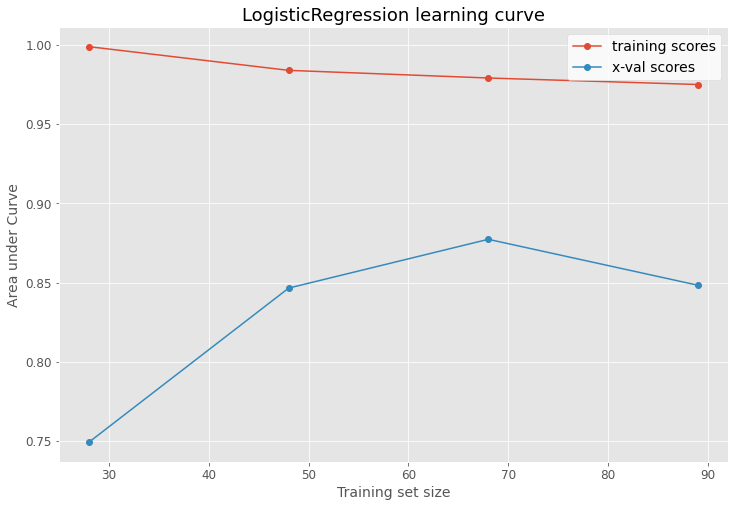

In [39]:
lr_clf = LogisticRegression(n_jobs = -1)
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Let's see if we can squeeze some more performance out by optimising C.

In [40]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)


param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
    }
lr_clf = LogisticRegression(random_state=0)


grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=cv, scoring='roc_auc', n_jobs=-1)

grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [41]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores       Params
0      0.868241      0.974061     {'C': 1}
1      0.860285      0.937221   {'C': 0.1}
2      0.848883      0.989852    {'C': 10}
3      0.820691      0.995732   {'C': 100}
4      0.813579      0.879488  {'C': 0.01}
5      0.805794      0.998050  {'C': 1000}

Looks like C=1 is our best value.

In [42]:
lr_clf = grid_search.best_estimator_
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'wb') as f:
    pickle.dump(lr_clf, f)

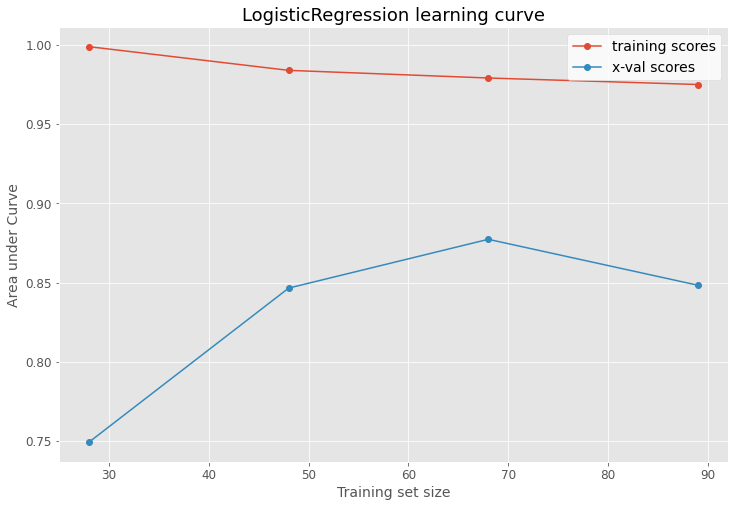

In [43]:
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Looks like the logistic regression model would benefit from additional data.

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

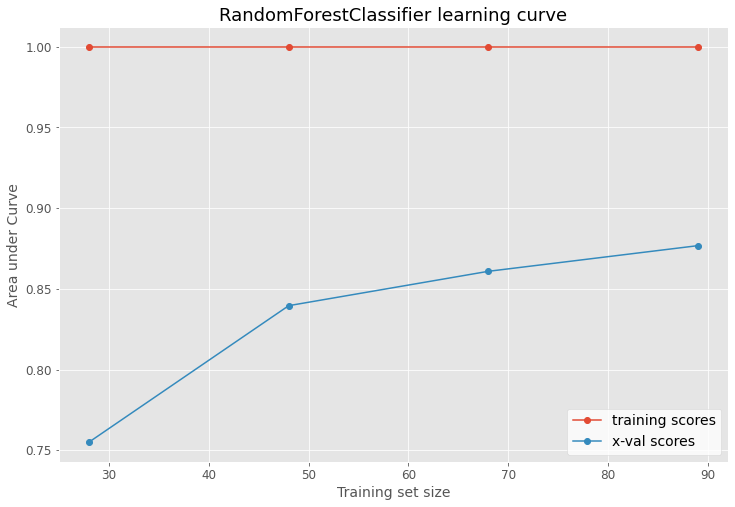

In [44]:
rf_clf = RandomForestClassifier(random_state=0)
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [45]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rf_clf = RandomForestClassifier(random_state=0)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=cv, scoring='roc_auc', random_state=0, n_jobs=-1)
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
                   estimator=RandomForestClassifier(random_state=0), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064AC553F98>,
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B0355438>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B03552B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064AEDEF4A8>},
                   random_state=0, return_train_score=True, scoring='roc_auc')

In [46]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.857861      0.982164   
1       0.834212      0.920658   
2       0.828237      0.910765   
3       0.827754      0.887006   
4       0.819921      0.880039   
..           ...           ...   
95      0.500000      0.500000   
96      0.500000      0.500000   
97      0.500000      0.500000   
98      0.500000      0.500000   
99      0.500000      0.500000   

                                               Params  
0   {'max_depth': 23, 'max_features': 'log2', 'min...  
1   {'max_depth': 38, 'max_features': 'log2', 'min...  
2   {'max_depth': 5, 'max_features': 'log2', 'min_...  
3   {'max_depth': 21, 'max_features': 'log2', 'min...  
4   {'max_depth': 41, 'max_features': 'auto', 'min...  
..                                                ...  
95  {'max_depth': 22, 'max_features': 'auto', 'min...  
96  {'max_depth': 49, 'max_features': 'auto', 'min...  
97  {'max_depth': 65, 'max_features': 'log2', 'min...  
98  {'max_depth': 62, 'max_features': 'log2', 'min...  
99  {'max_depth': 20, 'max_features': 'log2', 'min...  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

In [47]:
rf_clf = rnd_search.best_estimator_
rf_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'wb') as f:
    pickle.dump(rf_clf, f)

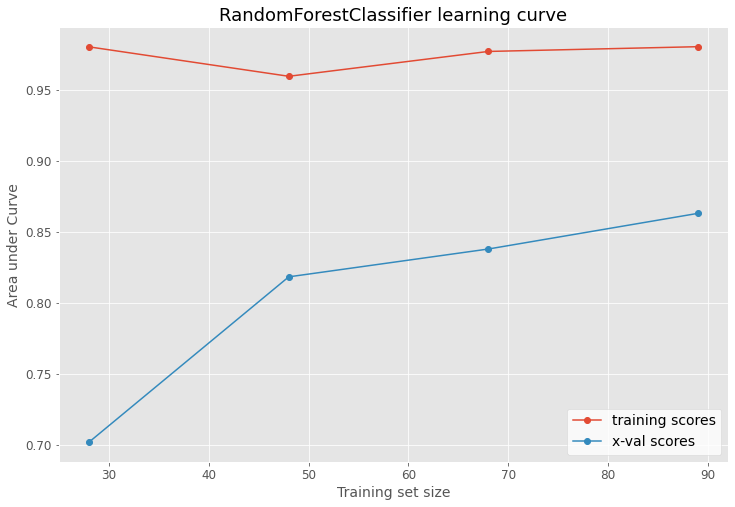

In [48]:
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

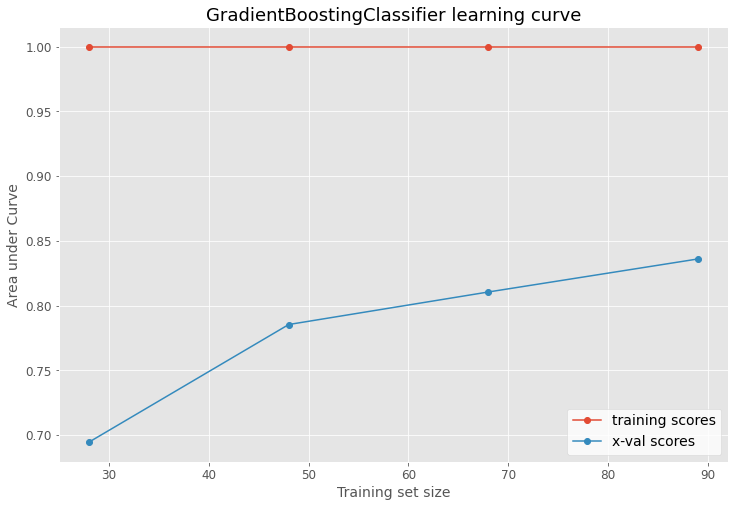

In [49]:
plot_learning_curves(GradientBoostingClassifier(random_state=0), data_train_X, data_train['Died'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [50]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=0), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=cv, scoring='roc_auc', random_state=0, n_jobs=-1)
# this will take a long time
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
                   estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B6ADEA90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B1BD7780>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B6ADE710>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000064B6ADE668>},
                   random_state=0, return_train_score=True, scoring='roc_auc')

In [51]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.864585      0.998994   
1       0.864260      0.999562   
2       0.863470      0.988224   
3       0.861323      0.999998   
4       0.858697      1.000000   
..           ...           ...   
95      0.500000      0.500000   
96      0.500000      0.500000   
97      0.500000      0.500000   
98      0.500000      0.500000   
99      0.500000      0.500000   

                                               Params  
0   {'max_depth': 38, 'min_samples_leaf': 13, 'min...  
1   {'max_depth': 46, 'min_samples_leaf': 15, 'min...  
2   {'max_depth': 27, 'min_samples_leaf': 14, 'min...  
3   {'max_depth': 18, 'min_samples_leaf': 13, 'min...  
4   {'max_depth': 43, 'min_samples_leaf': 13, 'min...  
..                                                ...  
95  {'max_depth': 30, 'min_samples_leaf': 95, 'min...  
96  {'max_depth': 22, 'min_samples_leaf': 74, 'min...  
97  {'max_depth': 16, 'min_samples_leaf': 60, 'min...  
98  {'max_depth': 3, 'min_samples_leaf': 77, 'min_...  
99  {'max_depth': 11, 'min_samples_leaf': 63, 'min...  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

In [52]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'wb') as f:
    pickle.dump(gbm_clf, f)

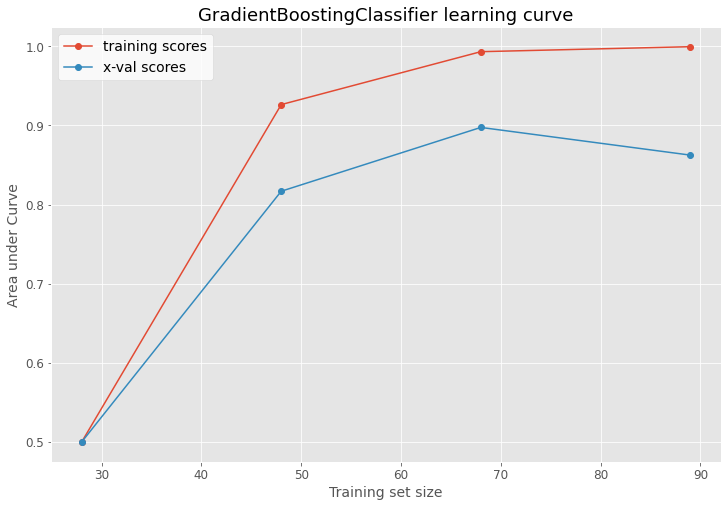

In [53]:
plot_learning_curves(gbm_clf, data_train_X, data_train['Died'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model dramatically improves with more 30 traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

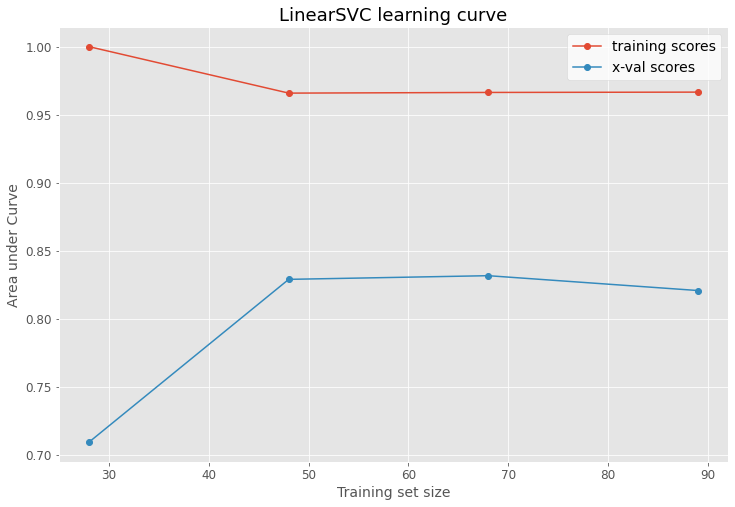

In [54]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=0), data_train_X, data_train['Died'])

Try Polynomial kernel

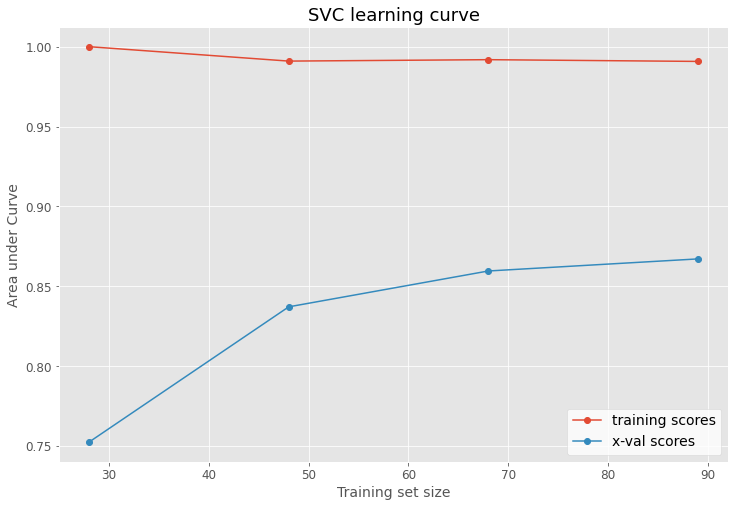

In [55]:
plot_learning_curves(SVC(kernel='poly', random_state=0), data_train_X, data_train['Died'])

Try Gaussian RBF kernel

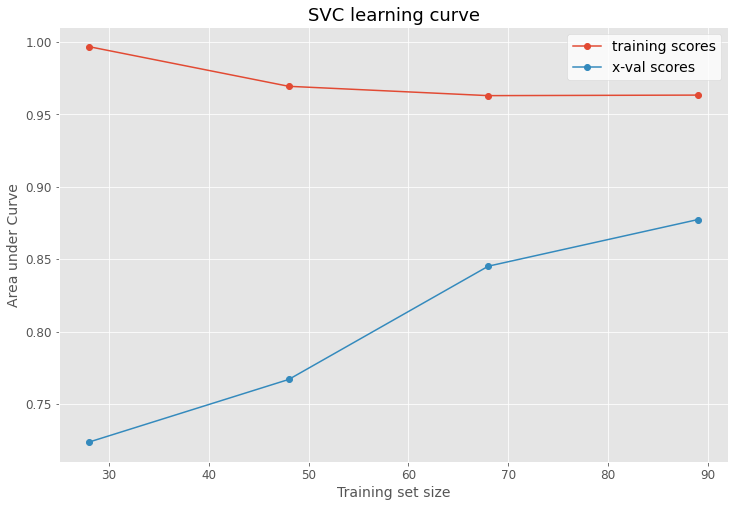

In [56]:
plot_learning_curves(SVC(kernel='rbf',random_state=0), data_train_X, data_train['Died'])

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [57]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

rbf_gamma = [1/len(data_train_X.columns) * x for x in range(1, 15, 5)] #range(1, 20, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 10, 100]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 10, 100]},
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=0), param_grid, cv=cv,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=SVC(probability=True, random_state=0), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'degree': [3, 9, 15],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100],
                          'gamma': [0.03571428571428571, 0.21428571428571427,
                                    0.39285714285714285]}],
             scoring='roc_auc')

In [58]:
cv_rlt = grid_search.cv_results_
#pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['std_test_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                      Params
0       0.878046      0.065175    {'C': 10, 'degree': 3, 'kernel': 'poly'}
1       0.878046      0.065175   {'C': 100, 'degree': 3, 'kernel': 'poly'}
2       0.877458      0.063258     {'C': 1, 'degree': 3, 'kernel': 'poly'}
3       0.868695      0.074432      {'C': 1, 'gamma': 0.03571428571428571}
4       0.867969      0.064568    {'C': 100, 'gamma': 0.03571428571428571}
5       0.867258      0.064303     {'C': 10, 'gamma': 0.03571428571428571}
6       0.853545      0.069661     {'C': 10, 'gamma': 0.21428571428571427}
7       0.853545      0.069661    {'C': 100, 'gamma': 0.21428571428571427}
8       0.851592      0.072183      {'C': 1, 'gamma': 0.21428571428571427}
9       0.849097      0.073104     {'C': 1, 'degree': 9, 'kernel': 'poly'}
10      0.825365      0.075838      {'C': 1, 'gamma': 0.39285714285714285}
11      0.824526      0.075005     {'C': 10, 'gamma': 0.39285714285714285}
12      0.824526      0.075005    {'C': 100, 'gamma': 0.39285714285714285}
13      0.818853      0.079353    {'C': 10, 'degree': 9, 'kernel': 'poly'}
14      0.818315      0.079400   {'C': 100, 'degree': 9, 'kernel': 'poly'}
15      0.815514      0.081860    {'C': 1, 'degree': 15, 'kernel': 'poly'}
16      0.791613      0.087581   {'C': 10, 'degree': 15, 'kernel': 'poly'}
17      0.766613      0.093292  {'C': 100, 'degree': 15, 'kernel': 'poly'}

SVM training is very computationaly expensive, making it not scalable to big data sets. As it turns out the default RBF SVM results the best cross-validation score.

In [59]:
svc_clf = grid_search.best_estimator_
svc_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

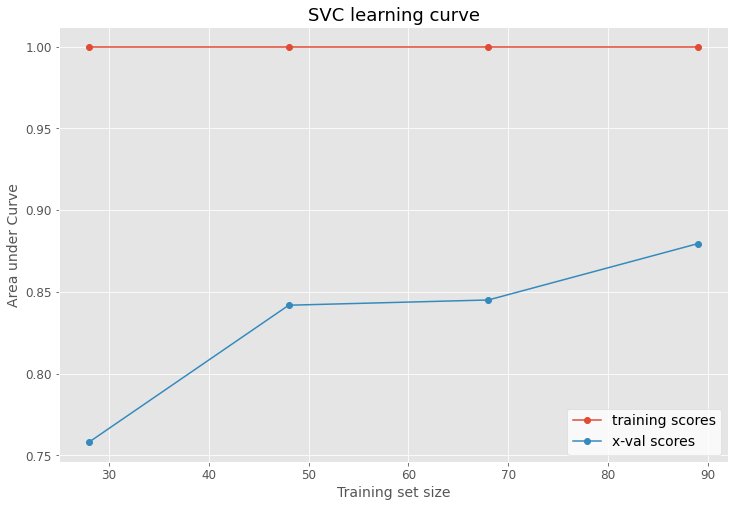

In [60]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['Died']) 

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

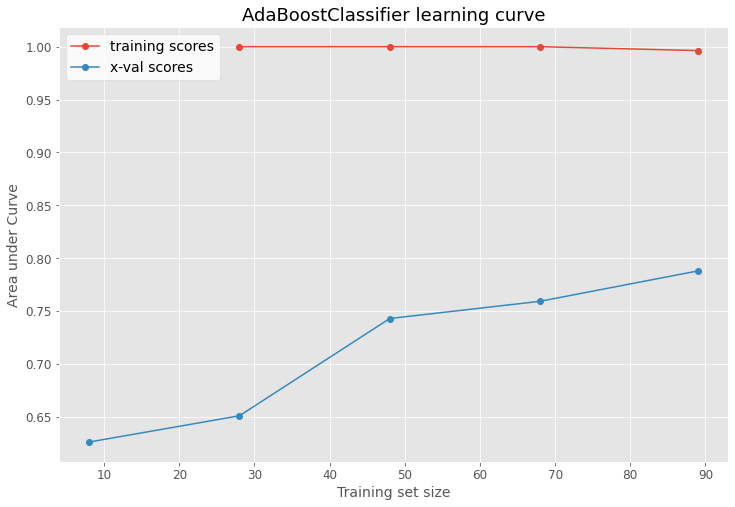

In [61]:
from sklearn.ensemble import AdaBoostClassifier

adab_clf = AdaBoostClassifier()
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

In [62]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_grid = {'n_estimators': [1,5,10,50],
        'learning_rate': [0.001,0.01,0.1,0.2,1] }
adab_clf = AdaBoostClassifier(random_state=0)
grid_search = GridSearchCV(adab_clf, param_grid=param_grid, return_train_score=True,
                           cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
                         'n_estimators': [1, 5, 10, 50]},
             return_train_score=True, scoring='roc_auc')

In [63]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                        Params
0       0.818581      0.937354    {'learning_rate': 0.1, 'n_estimators': 50}
1       0.817944      0.962811    {'learning_rate': 0.2, 'n_estimators': 50}
2       0.803556      0.995823      {'learning_rate': 1, 'n_estimators': 50}
3       0.802340      0.894389    {'learning_rate': 0.2, 'n_estimators': 10}
4       0.798584      0.949176      {'learning_rate': 1, 'n_estimators': 10}
5       0.779505      0.898431       {'learning_rate': 1, 'n_estimators': 5}
6       0.776026      0.864175    {'learning_rate': 0.1, 'n_estimators': 10}
7       0.766553      0.855475     {'learning_rate': 0.2, 'n_estimators': 5}
8       0.751568      0.838971   {'learning_rate': 0.01, 'n_estimators': 50}
9       0.736347      0.826879     {'learning_rate': 0.1, 'n_estimators': 5}
10      0.669050      0.752934   {'learning_rate': 0.01, 'n_estimators': 10}
11      0.654760      0.733980  {'learning_rate': 0.001, 'n_estimators': 50}
12      0.650620      0.728569    {'learning_rate': 0.01, 'n_estimators': 5}
13      0.634854      0.709879  {'learning_rate': 0.001, 'n_estimators': 10}
14      0.633326      0.707504   {'learning_rate': 0.001, 'n_estimators': 5}
15      0.631397      0.705319   {'learning_rate': 0.001, 'n_estimators': 1}
16      0.631397      0.705319    {'learning_rate': 0.01, 'n_estimators': 1}
17      0.631397      0.705319     {'learning_rate': 0.1, 'n_estimators': 1}
18      0.631397      0.705319     {'learning_rate': 0.2, 'n_estimators': 1}
19      0.631397      0.705319       {'learning_rate': 1, 'n_estimators': 1}

In [64]:
adab_clf = grid_search.best_estimator_
adab_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'wb') as f:
    pickle.dump(adab_clf, f)

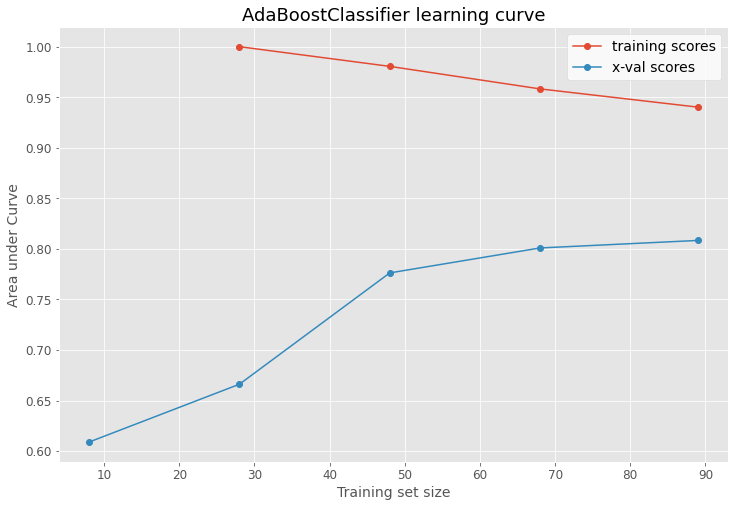

In [65]:
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

### Ensemble classifier
Scikit-learn offers a voting classifier which aggregates the prediction of multiple predictors and is a flexible ensemble technique that allows an ensemble of different models.  
For the final classifier, simply aggregate the predictions of the three best models, i.e., logistic regression,random forests, gradien boosting machine and the support vector machine.
https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets

In [66]:
#ensemble_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf)],
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf), ('adab', adab_clf)],
                             voting='soft')
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=0)),
                             ('rf',
                              RandomForestClassifier(max_depth=23,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=12,
                                                     n_estimators=44,
                                                     random_state=0)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=38,
                                                         min_samples_leaf=13,
                                                         min_samples_split=48,
                                                         n_estimators=162,
                                                         random_state=0)),
                             ('svc',
    

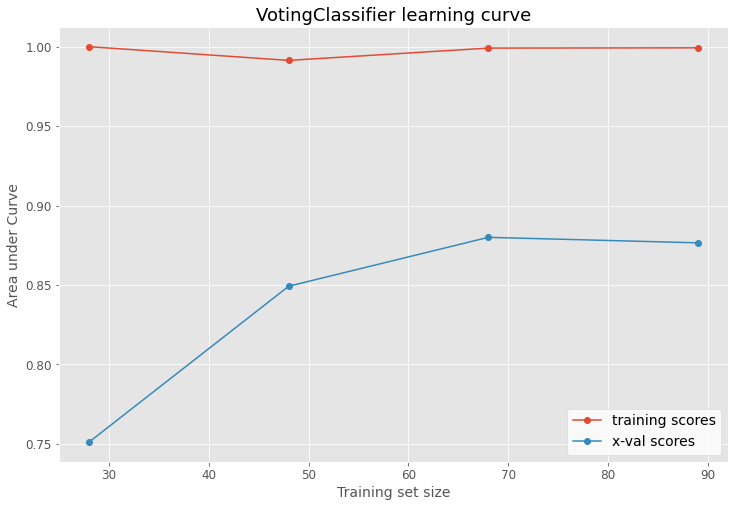

In [67]:
plot_learning_curves(ensemble_clf, data_train_X, data_train['Died'])

In [68]:
#ensemble_clf = grid_search.best_estimator_
ensemble_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'wb') as f:
    pickle.dump(ensemble_clf, f)

## 6. Compute and compare test metrics

**Transform test data set**

In [69]:
data_test_X = pd.DataFrame(preproc_pipeline.transform(data_test), # it's imperative not to do fit_transfomr again
                           columns=categorical_vars + continuous_vars)
#columns=categorical_vars + numerical_vars)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [70]:
data_test_X.shape

(38, 28)

In [71]:
data_test_X.head()

Gender  Age  BMI  Comorbidity_diabetes  Comorbidity_hypertension  \
0       0    2    0                     0                         0   
1       0    1    1                     0                         0   
2       0    2    2                     0                         0   
3       0    1    2                     0                         1   
4       1    2    2                     0                         1   

   Comorbidity_CAD  Comorbidity_pulmonary  Comorbidity_hepatic  \
0                1                      1                    0   
1                0                      0                    0   
2                0                      0                    0   
3                1                      1                    0   
4                1                      0                    0   

   Comorbidity_renal  Comorbidity_neurological  ...  Defibrillate  \
0                  0                         1  ...             0   
1                  0                         0  ...             0   
2                  0                         0  ...             1   
3                  0                         0  ...             0   
4                  0                         0  ...             0   

   Cause_arrest  Hemorrhage  Blood_transfusion  Epinephrine  Atropine  \
0             1           0                  0            1         0   
1             3           2                  2            1         0   
2             1           0                  0            1         0   
3             1           1                  0            2         1   
4             2           2                  2            2         0   

   Amiodarone  Ephedrine  Methoxamine  CPR  
0           0          0            1    0  
1           0          0            0    1  
2           1          0            0    2  
3           0          0            0    2  
4           0          0            0    1  

[5 rows x 28 columns]

**Compute test accuracy score**

In [72]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

### _Logistic Regression model_

In [73]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(data_train_X, data_train['Died'])

LogisticRegression(C=1, random_state=0)

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c

In [74]:
import scipy.stats


y_pred = np.array(lr_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.711
Bootstrap #1 ROC area: 0.769
Bootstrap #2 ROC area: 0.723
Bootstrap #3 ROC area: 0.710
Bootstrap #4 ROC area: 0.653
Bootstrap #5 ROC area: 0.684
Bootstrap #6 ROC area: 0.632
Bootstrap #7 ROC area: 0.726
Bootstrap #8 ROC area: 0.748
Bootstrap #9 ROC area: 0.585
Bootstrap #10 ROC area: 0.711
Bootstrap #11 ROC area: 0.739
Bootstrap #12 ROC area: 0.693
Bootstrap #13 ROC area: 0.569
Bootstrap #14 ROC area: 0.932
Bootstrap #15 ROC area: 0.640
Bootstrap #16 ROC area: 0.739
Bootstrap #17 ROC area: 0.780
Bootstrap #18 ROC area: 0.737
Bootstrap #19 ROC area: 0.758
Bootstrap #20 ROC area: 0.814
Bootstrap #21 ROC area: 0.678
Bootstrap #22 ROC area: 0.727
Bootstrap #23 ROC area: 0.721
Bootstrap #24 ROC area: 0.852
Bootstrap #25 ROC area: 0.761
Bootstrap #26 ROC area: 0.780
Bootstrap #27 ROC area: 0.662
Bootstrap #28 ROC area: 0.763
Bootstrap #29 ROC area: 0.658
Bootstrap #30 ROC area: 0.814
Bootstrap #31 ROC area: 0.737
Bootstrap #32 ROC area: 0.560
Bootstrap #33 ROC area: 

Bootstrap #309 ROC area: 0.791
Bootstrap #310 ROC area: 0.553
Bootstrap #311 ROC area: 0.628
Bootstrap #312 ROC area: 0.748
Bootstrap #313 ROC area: 0.819
Bootstrap #314 ROC area: 0.753
Bootstrap #315 ROC area: 0.762
Bootstrap #316 ROC area: 0.586
Bootstrap #317 ROC area: 0.763
Bootstrap #318 ROC area: 0.585
Bootstrap #319 ROC area: 0.761
Bootstrap #320 ROC area: 0.775
Bootstrap #321 ROC area: 0.764
Bootstrap #322 ROC area: 0.686
Bootstrap #323 ROC area: 0.577
Bootstrap #324 ROC area: 0.801
Bootstrap #325 ROC area: 0.711
Bootstrap #326 ROC area: 0.681
Bootstrap #327 ROC area: 0.730
Bootstrap #328 ROC area: 0.761
Bootstrap #329 ROC area: 0.583
Bootstrap #330 ROC area: 0.634
Bootstrap #331 ROC area: 0.685
Bootstrap #332 ROC area: 0.710
Bootstrap #333 ROC area: 0.816
Bootstrap #334 ROC area: 0.752
Bootstrap #335 ROC area: 0.795
Bootstrap #336 ROC area: 0.819
Bootstrap #337 ROC area: 0.641
Bootstrap #338 ROC area: 0.645
Bootstrap #339 ROC area: 0.726
Bootstrap #340 ROC area: 0.616
Bootstra

Bootstrap #576 ROC area: 0.704
Bootstrap #577 ROC area: 0.662
Bootstrap #578 ROC area: 0.712
Bootstrap #579 ROC area: 0.763
Bootstrap #580 ROC area: 0.739
Bootstrap #581 ROC area: 0.676
Bootstrap #582 ROC area: 0.757
Bootstrap #583 ROC area: 0.739
Bootstrap #584 ROC area: 0.737
Bootstrap #585 ROC area: 0.724
Bootstrap #586 ROC area: 0.825
Bootstrap #587 ROC area: 0.770
Bootstrap #588 ROC area: 0.683
Bootstrap #589 ROC area: 0.840
Bootstrap #590 ROC area: 0.707
Bootstrap #591 ROC area: 0.658
Bootstrap #592 ROC area: 0.728
Bootstrap #593 ROC area: 0.738
Bootstrap #594 ROC area: 0.703
Bootstrap #595 ROC area: 0.769
Bootstrap #596 ROC area: 0.668
Bootstrap #597 ROC area: 0.683
Bootstrap #598 ROC area: 0.786
Bootstrap #599 ROC area: 0.716
Bootstrap #600 ROC area: 0.830
Bootstrap #601 ROC area: 0.650
Bootstrap #602 ROC area: 0.664
Bootstrap #603 ROC area: 0.743
Bootstrap #604 ROC area: 0.805
Bootstrap #605 ROC area: 0.736
Bootstrap #606 ROC area: 0.798
Bootstrap #607 ROC area: 0.756
Bootstra

Bootstrap #840 ROC area: 0.780
Bootstrap #841 ROC area: 0.734
Bootstrap #842 ROC area: 0.605
Bootstrap #843 ROC area: 0.815
Bootstrap #844 ROC area: 0.604
Bootstrap #845 ROC area: 0.723
Bootstrap #846 ROC area: 0.814
Bootstrap #847 ROC area: 0.689
Bootstrap #848 ROC area: 0.608
Bootstrap #849 ROC area: 0.683
Bootstrap #850 ROC area: 0.708
Bootstrap #851 ROC area: 0.598
Bootstrap #852 ROC area: 0.736
Bootstrap #853 ROC area: 0.669
Bootstrap #854 ROC area: 0.639
Bootstrap #855 ROC area: 0.662
Bootstrap #856 ROC area: 0.711
Bootstrap #857 ROC area: 0.736
Bootstrap #858 ROC area: 0.622
Bootstrap #859 ROC area: 0.793
Bootstrap #860 ROC area: 0.739
Bootstrap #861 ROC area: 0.658
Bootstrap #862 ROC area: 0.603
Bootstrap #863 ROC area: 0.681
Bootstrap #864 ROC area: 0.545
Bootstrap #865 ROC area: 0.792
Bootstrap #866 ROC area: 0.739
Bootstrap #867 ROC area: 0.708
Bootstrap #868 ROC area: 0.656
Bootstrap #869 ROC area: 0.632
Bootstrap #870 ROC area: 0.747
Bootstrap #871 ROC area: 0.733
Bootstra

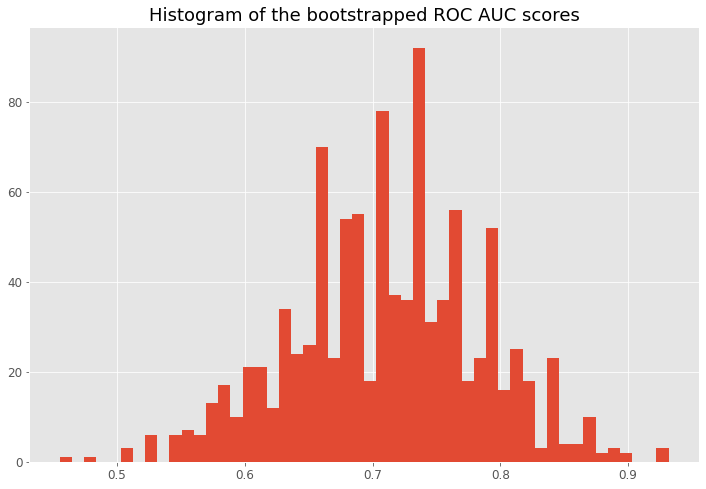

In [75]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [76]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.562 - 0.855]


classification_report

In [77]:
print(classification_report(data_test['Died'], lr_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.74      0.70      0.72        20

    accuracy                           0.71        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.71      0.71      0.71        38



Accuracy scores

In [78]:
accu_lr = accuracy_score(data_test['Died'], lr_clf.predict(data_test_X))

In [79]:
accu_lr

0.7105263157894737

In [80]:
pd.crosstab(data_test['Died'], lr_clf.predict(data_test_X))

col_0   0   1
Died         
0      13   5
1       6  14

ROC and AUC

In [81]:
pred_proba_lr = lr_clf.predict_proba(data_test_X)

In [82]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(data_test['Died'], pred_proba_lr[:, 1])

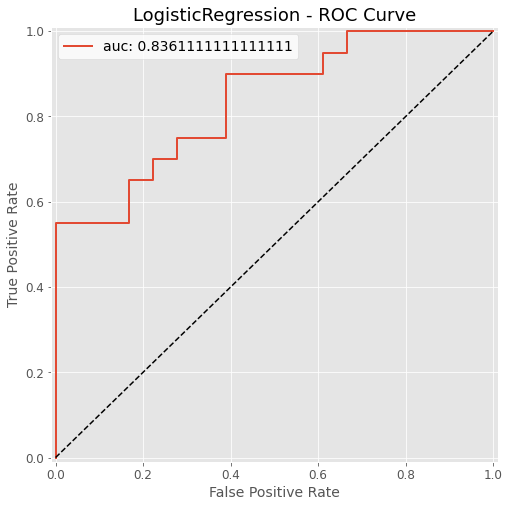

In [83]:
plot_roc_curve(fpr, tpr, auc_lr, lr_clf)

### _Random forests model_

In [84]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(data_train_X, data_train['Died'])

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=44, random_state=0)

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [85]:
import scipy.stats

y_pred = np.array(rf_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.817
Bootstrap #1 ROC area: 0.745
Bootstrap #2 ROC area: 0.835
Bootstrap #3 ROC area: 0.912
Bootstrap #4 ROC area: 0.690
Bootstrap #5 ROC area: 0.763
Bootstrap #6 ROC area: 0.816
Bootstrap #7 ROC area: 0.735
Bootstrap #8 ROC area: 0.825
Bootstrap #9 ROC area: 0.739
Bootstrap #10 ROC area: 0.868
Bootstrap #11 ROC area: 0.844
Bootstrap #12 ROC area: 0.901
Bootstrap #13 ROC area: 0.899
Bootstrap #14 ROC area: 0.923
Bootstrap #15 ROC area: 0.845
Bootstrap #16 ROC area: 0.814
Bootstrap #17 ROC area: 0.835
Bootstrap #18 ROC area: 0.816
Bootstrap #19 ROC area: 0.767
Bootstrap #20 ROC area: 0.864
Bootstrap #21 ROC area: 0.680
Bootstrap #22 ROC area: 0.846
Bootstrap #23 ROC area: 0.840
Bootstrap #24 ROC area: 0.838
Bootstrap #25 ROC area: 0.923
Bootstrap #26 ROC area: 0.801
Bootstrap #27 ROC area: 0.721
Bootstrap #28 ROC area: 0.868
Bootstrap #29 ROC area: 0.737
Bootstrap #30 ROC area: 0.847
Bootstrap #31 ROC area: 0.868
Bootstrap #32 ROC area: 0.830
Bootstrap #33 ROC area: 

Bootstrap #302 ROC area: 0.786
Bootstrap #303 ROC area: 0.789
Bootstrap #304 ROC area: 0.921
Bootstrap #305 ROC area: 0.964
Bootstrap #306 ROC area: 0.645
Bootstrap #307 ROC area: 0.901
Bootstrap #308 ROC area: 0.717
Bootstrap #309 ROC area: 0.823
Bootstrap #310 ROC area: 0.814
Bootstrap #311 ROC area: 0.761
Bootstrap #312 ROC area: 0.791
Bootstrap #313 ROC area: 0.844
Bootstrap #314 ROC area: 0.830
Bootstrap #315 ROC area: 0.783
Bootstrap #316 ROC area: 0.819
Bootstrap #317 ROC area: 0.739
Bootstrap #318 ROC area: 0.692
Bootstrap #319 ROC area: 0.824
Bootstrap #320 ROC area: 0.852
Bootstrap #321 ROC area: 0.764
Bootstrap #322 ROC area: 0.786
Bootstrap #323 ROC area: 0.761
Bootstrap #324 ROC area: 0.843
Bootstrap #325 ROC area: 0.684
Bootstrap #326 ROC area: 0.840
Bootstrap #327 ROC area: 0.838
Bootstrap #328 ROC area: 0.869
Bootstrap #329 ROC area: 0.769
Bootstrap #330 ROC area: 0.839
Bootstrap #331 ROC area: 0.722
Bootstrap #332 ROC area: 0.852
Bootstrap #333 ROC area: 0.842
Bootstra

Bootstrap #577 ROC area: 0.758
Bootstrap #578 ROC area: 0.935
Bootstrap #579 ROC area: 0.842
Bootstrap #580 ROC area: 0.751
Bootstrap #581 ROC area: 0.810
Bootstrap #582 ROC area: 0.880
Bootstrap #583 ROC area: 0.793
Bootstrap #584 ROC area: 0.816
Bootstrap #585 ROC area: 0.730
Bootstrap #586 ROC area: 0.883
Bootstrap #587 ROC area: 0.810
Bootstrap #588 ROC area: 0.758
Bootstrap #589 ROC area: 0.859
Bootstrap #590 ROC area: 0.716
Bootstrap #591 ROC area: 0.897
Bootstrap #592 ROC area: 0.861
Bootstrap #593 ROC area: 0.726
Bootstrap #594 ROC area: 0.835
Bootstrap #595 ROC area: 0.846
Bootstrap #596 ROC area: 0.805
Bootstrap #597 ROC area: 0.817
Bootstrap #598 ROC area: 0.897
Bootstrap #599 ROC area: 0.855
Bootstrap #600 ROC area: 0.839
Bootstrap #601 ROC area: 0.839
Bootstrap #602 ROC area: 0.864
Bootstrap #603 ROC area: 0.863
Bootstrap #604 ROC area: 0.689
Bootstrap #605 ROC area: 0.844
Bootstrap #606 ROC area: 0.787
Bootstrap #607 ROC area: 0.869
Bootstrap #608 ROC area: 0.836
Bootstra

Bootstrap #901 ROC area: 0.861
Bootstrap #902 ROC area: 0.656
Bootstrap #903 ROC area: 0.789
Bootstrap #904 ROC area: 0.901
Bootstrap #905 ROC area: 0.868
Bootstrap #906 ROC area: 0.763
Bootstrap #907 ROC area: 0.947
Bootstrap #908 ROC area: 0.952
Bootstrap #909 ROC area: 0.842
Bootstrap #910 ROC area: 0.890
Bootstrap #911 ROC area: 0.686
Bootstrap #912 ROC area: 0.711
Bootstrap #913 ROC area: 0.775
Bootstrap #914 ROC area: 0.817
Bootstrap #915 ROC area: 0.855
Bootstrap #916 ROC area: 0.819
Bootstrap #917 ROC area: 0.728
Bootstrap #918 ROC area: 0.763
Bootstrap #919 ROC area: 0.758
Bootstrap #920 ROC area: 0.923
Bootstrap #921 ROC area: 0.737
Bootstrap #922 ROC area: 0.843
Bootstrap #923 ROC area: 0.858
Bootstrap #924 ROC area: 0.869
Bootstrap #925 ROC area: 0.880
Bootstrap #926 ROC area: 0.676
Bootstrap #927 ROC area: 0.835
Bootstrap #928 ROC area: 0.791
Bootstrap #929 ROC area: 0.686
Bootstrap #930 ROC area: 0.823
Bootstrap #931 ROC area: 0.817
Bootstrap #932 ROC area: 0.872
Bootstra

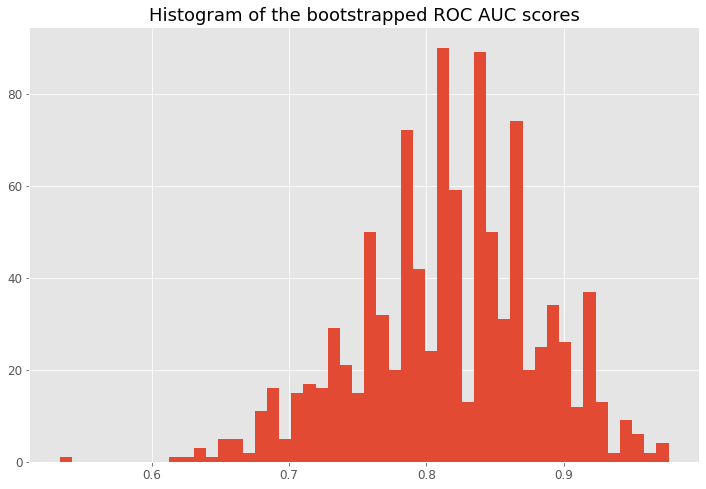

In [86]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [87]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.680 - 0.932]


Classification_report

In [88]:
print(classification_report(data_test['Died'], rf_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.84      0.80      0.82        20

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



Accuracy scores

In [89]:
accu_rf = accuracy_score(data_test['Died'], rf_clf.predict(data_test_X))

In [90]:
accu_rf

0.8157894736842105

In [91]:
pd.crosstab(data_test['Died'], rf_clf.predict(data_test_X))

col_0   0   1
Died         
0      15   3
1       4  16

ROC and AUC

In [92]:
pred_proba_rf = rf_clf.predict_proba(data_test_X)

In [93]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(data_test['Died'], pred_proba_rf[:, 1])

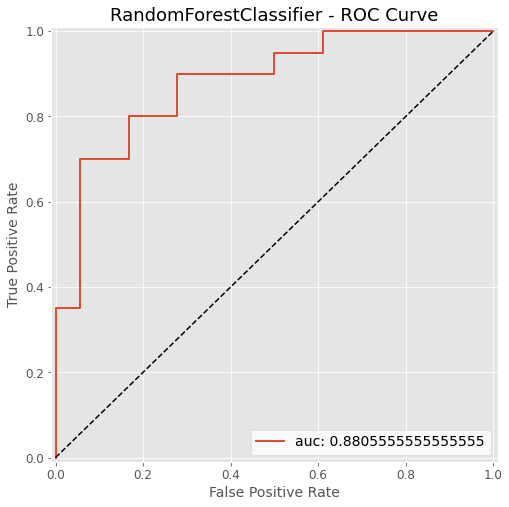

In [94]:
plot_roc_curve(fpr, tpr, auc_rf, rf_clf)

### _Gradient boosting machine model_

In [95]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(data_train_X, data_train['Died'])

GradientBoostingClassifier(max_depth=38, min_samples_leaf=13,
                           min_samples_split=48, n_estimators=162,
                           random_state=0)

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [96]:
import scipy.stats

y_pred = np.array(gbm_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.817
Bootstrap #1 ROC area: 0.793
Bootstrap #2 ROC area: 0.805
Bootstrap #3 ROC area: 0.941
Bootstrap #4 ROC area: 0.668
Bootstrap #5 ROC area: 0.711
Bootstrap #6 ROC area: 0.816
Bootstrap #7 ROC area: 0.801
Bootstrap #8 ROC area: 0.825
Bootstrap #9 ROC area: 0.761
Bootstrap #10 ROC area: 0.921
Bootstrap #11 ROC area: 0.844
Bootstrap #12 ROC area: 0.901
Bootstrap #13 ROC area: 0.923
Bootstrap #14 ROC area: 0.923
Bootstrap #15 ROC area: 0.824
Bootstrap #16 ROC area: 0.786
Bootstrap #17 ROC area: 0.835
Bootstrap #18 ROC area: 0.789
Bootstrap #19 ROC area: 0.817
Bootstrap #20 ROC area: 0.919
Bootstrap #21 ROC area: 0.588
Bootstrap #22 ROC area: 0.798
Bootstrap #23 ROC area: 0.870
Bootstrap #24 ROC area: 0.807
Bootstrap #25 ROC area: 0.923
Bootstrap #26 ROC area: 0.801
Bootstrap #27 ROC area: 0.751
Bootstrap #28 ROC area: 0.868
Bootstrap #29 ROC area: 0.789
Bootstrap #30 ROC area: 0.822
Bootstrap #31 ROC area: 0.895
Bootstrap #32 ROC area: 0.830
Bootstrap #33 ROC area: 

Bootstrap #318 ROC area: 0.716
Bootstrap #319 ROC area: 0.824
Bootstrap #320 ROC area: 0.828
Bootstrap #321 ROC area: 0.764
Bootstrap #322 ROC area: 0.736
Bootstrap #323 ROC area: 0.730
Bootstrap #324 ROC area: 0.843
Bootstrap #325 ROC area: 0.684
Bootstrap #326 ROC area: 0.840
Bootstrap #327 ROC area: 0.869
Bootstrap #328 ROC area: 0.892
Bootstrap #329 ROC area: 0.719
Bootstrap #330 ROC area: 0.860
Bootstrap #331 ROC area: 0.699
Bootstrap #332 ROC area: 0.899
Bootstrap #333 ROC area: 0.895
Bootstrap #334 ROC area: 0.840
Bootstrap #335 ROC area: 0.908
Bootstrap #336 ROC area: 0.819
Bootstrap #337 ROC area: 0.740
Bootstrap #338 ROC area: 0.838
Bootstrap #339 ROC area: 0.711
Bootstrap #340 ROC area: 0.884
Bootstrap #341 ROC area: 0.819
Bootstrap #342 ROC area: 0.691
Bootstrap #343 ROC area: 0.744
Bootstrap #344 ROC area: 0.782
Bootstrap #345 ROC area: 0.770
Bootstrap #346 ROC area: 0.734
Bootstrap #347 ROC area: 0.825
Bootstrap #348 ROC area: 0.781
Bootstrap #349 ROC area: 0.588
Bootstra

Bootstrap #584 ROC area: 0.816
Bootstrap #585 ROC area: 0.793
Bootstrap #586 ROC area: 0.863
Bootstrap #587 ROC area: 0.832
Bootstrap #588 ROC area: 0.758
Bootstrap #589 ROC area: 0.917
Bootstrap #590 ROC area: 0.739
Bootstrap #591 ROC area: 0.922
Bootstrap #592 ROC area: 0.889
Bootstrap #593 ROC area: 0.704
Bootstrap #594 ROC area: 0.857
Bootstrap #595 ROC area: 0.846
Bootstrap #596 ROC area: 0.785
Bootstrap #597 ROC area: 0.789
Bootstrap #598 ROC area: 0.947
Bootstrap #599 ROC area: 0.878
Bootstrap #600 ROC area: 0.902
Bootstrap #601 ROC area: 0.814
Bootstrap #602 ROC area: 0.814
Bootstrap #603 ROC area: 0.843
Bootstrap #604 ROC area: 0.728
Bootstrap #605 ROC area: 0.817
Bootstrap #606 ROC area: 0.811
Bootstrap #607 ROC area: 0.901
Bootstrap #608 ROC area: 0.880
Bootstrap #609 ROC area: 0.851
Bootstrap #610 ROC area: 0.816
Bootstrap #611 ROC area: 0.842
Bootstrap #612 ROC area: 0.872
Bootstrap #613 ROC area: 0.842
Bootstrap #614 ROC area: 0.765
Bootstrap #615 ROC area: 0.923
Bootstra

Bootstrap #867 ROC area: 0.764
Bootstrap #868 ROC area: 0.836
Bootstrap #869 ROC area: 0.711
Bootstrap #870 ROC area: 0.845
Bootstrap #871 ROC area: 0.786
Bootstrap #872 ROC area: 0.816
Bootstrap #873 ROC area: 0.816
Bootstrap #874 ROC area: 0.842
Bootstrap #875 ROC area: 0.840
Bootstrap #876 ROC area: 0.739
Bootstrap #877 ROC area: 0.814
Bootstrap #878 ROC area: 0.824
Bootstrap #879 ROC area: 0.840
Bootstrap #880 ROC area: 0.923
Bootstrap #881 ROC area: 0.840
Bootstrap #882 ROC area: 0.878
Bootstrap #883 ROC area: 0.790
Bootstrap #884 ROC area: 0.699
Bootstrap #885 ROC area: 0.880
Bootstrap #886 ROC area: 0.789
Bootstrap #887 ROC area: 0.880
Bootstrap #888 ROC area: 0.793
Bootstrap #889 ROC area: 0.908
Bootstrap #890 ROC area: 0.817
Bootstrap #891 ROC area: 0.895
Bootstrap #892 ROC area: 0.789
Bootstrap #893 ROC area: 0.811
Bootstrap #894 ROC area: 0.839
Bootstrap #895 ROC area: 0.746
Bootstrap #896 ROC area: 0.778
Bootstrap #897 ROC area: 0.787
Bootstrap #898 ROC area: 0.751
Bootstra

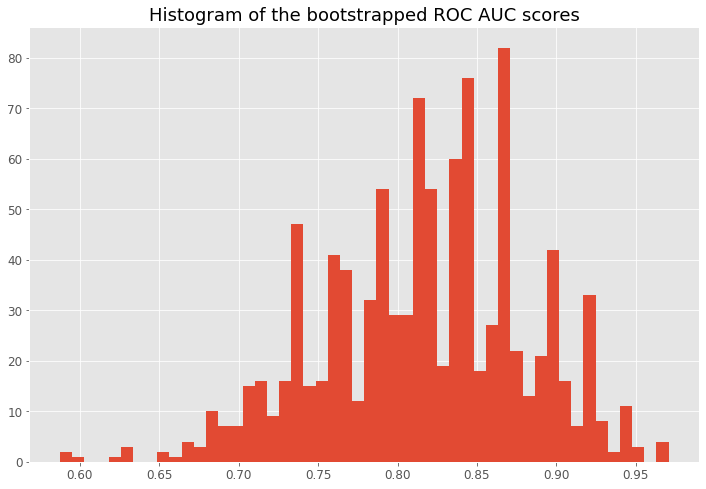

In [97]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [98]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.686 - 0.929]


Classification_report

In [99]:
print(classification_report(data_test['Died'], gbm_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.84      0.80      0.82        20

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



Accuracy scores

In [100]:
accu_gbm = accuracy_score(data_test['Died'], gbm_clf.predict(data_test_X))

In [101]:
accu_gbm

0.8157894736842105

In [102]:
pd.crosstab(data_test['Died'], gbm_clf.predict(data_test_X))

col_0   0   1
Died         
0      15   3
1       4  16

ROC and AUC

In [103]:
pred_proba_gbm = gbm_clf.predict_proba(data_test_X)

In [104]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_test['Died'], pred_proba_gbm[:, 1])

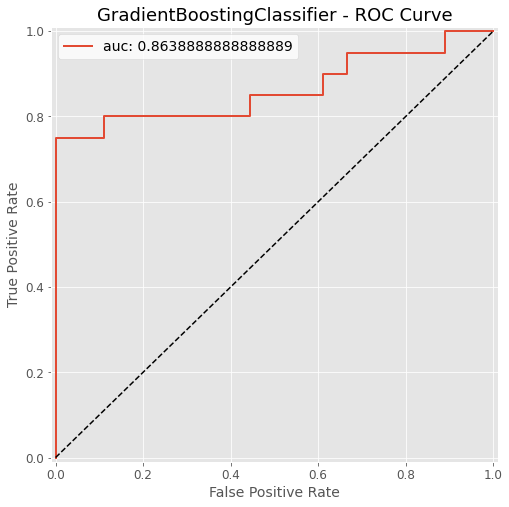

In [105]:
plot_roc_curve(fpr, tpr, auc_gbm, gbm_clf)

### _Support vector machine model_

In [106]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(data_train_X, data_train['Died'])

SVC(C=10, kernel='poly', probability=True, random_state=0)

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [107]:
import scipy.stats

y_pred = np.array(svc_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.736
Bootstrap #1 ROC area: 0.817
Bootstrap #2 ROC area: 0.752
Bootstrap #3 ROC area: 0.769
Bootstrap #4 ROC area: 0.676
Bootstrap #5 ROC area: 0.711
Bootstrap #6 ROC area: 0.658
Bootstrap #7 ROC area: 0.726
Bootstrap #8 ROC area: 0.748
Bootstrap #9 ROC area: 0.608
Bootstrap #10 ROC area: 0.737
Bootstrap #11 ROC area: 0.739
Bootstrap #12 ROC area: 0.724
Bootstrap #13 ROC area: 0.616
Bootstrap #14 ROC area: 0.955
Bootstrap #15 ROC area: 0.640
Bootstrap #16 ROC area: 0.767
Bootstrap #17 ROC area: 0.801
Bootstrap #18 ROC area: 0.737
Bootstrap #19 ROC area: 0.783
Bootstrap #20 ROC area: 0.814
Bootstrap #21 ROC area: 0.697
Bootstrap #22 ROC area: 0.775
Bootstrap #23 ROC area: 0.751
Bootstrap #24 ROC area: 0.852
Bootstrap #25 ROC area: 0.784
Bootstrap #26 ROC area: 0.851
Bootstrap #27 ROC area: 0.662
Bootstrap #28 ROC area: 0.763
Bootstrap #29 ROC area: 0.737
Bootstrap #30 ROC area: 0.814
Bootstrap #31 ROC area: 0.816
Bootstrap #32 ROC area: 0.591
Bootstrap #33 ROC area: 

Bootstrap #315 ROC area: 0.762
Bootstrap #316 ROC area: 0.611
Bootstrap #317 ROC area: 0.763
Bootstrap #318 ROC area: 0.657
Bootstrap #319 ROC area: 0.761
Bootstrap #320 ROC area: 0.798
Bootstrap #321 ROC area: 0.789
Bootstrap #322 ROC area: 0.686
Bootstrap #323 ROC area: 0.608
Bootstrap #324 ROC area: 0.801
Bootstrap #325 ROC area: 0.737
Bootstrap #326 ROC area: 0.681
Bootstrap #327 ROC area: 0.761
Bootstrap #328 ROC area: 0.784
Bootstrap #329 ROC area: 0.658
Bootstrap #330 ROC area: 0.717
Bootstrap #331 ROC area: 0.730
Bootstrap #332 ROC area: 0.758
Bootstrap #333 ROC area: 0.842
Bootstrap #334 ROC area: 0.811
Bootstrap #335 ROC area: 0.830
Bootstrap #336 ROC area: 0.819
Bootstrap #337 ROC area: 0.699
Bootstrap #338 ROC area: 0.668
Bootstrap #339 ROC area: 0.747
Bootstrap #340 ROC area: 0.616
Bootstrap #341 ROC area: 0.711
Bootstrap #342 ROC area: 0.603
Bootstrap #343 ROC area: 0.776
Bootstrap #344 ROC area: 0.699
Bootstrap #345 ROC area: 0.770
Bootstrap #346 ROC area: 0.763
Bootstra

Bootstrap #590 ROC area: 0.707
Bootstrap #591 ROC area: 0.683
Bootstrap #592 ROC area: 0.756
Bootstrap #593 ROC area: 0.738
Bootstrap #594 ROC area: 0.703
Bootstrap #595 ROC area: 0.769
Bootstrap #596 ROC area: 0.668
Bootstrap #597 ROC area: 0.683
Bootstrap #598 ROC area: 0.811
Bootstrap #599 ROC area: 0.761
Bootstrap #600 ROC area: 0.830
Bootstrap #601 ROC area: 0.650
Bootstrap #602 ROC area: 0.689
Bootstrap #603 ROC area: 0.803
Bootstrap #604 ROC area: 0.805
Bootstrap #605 ROC area: 0.819
Bootstrap #606 ROC area: 0.846
Bootstrap #607 ROC area: 0.787
Bootstrap #608 ROC area: 0.813
Bootstrap #609 ROC area: 0.881
Bootstrap #610 ROC area: 0.737
Bootstrap #611 ROC area: 0.684
Bootstrap #612 ROC area: 0.736
Bootstrap #613 ROC area: 0.736
Bootstrap #614 ROC area: 0.823
Bootstrap #615 ROC area: 0.707
Bootstrap #616 ROC area: 0.684
Bootstrap #617 ROC area: 0.658
Bootstrap #618 ROC area: 0.763
Bootstrap #619 ROC area: 0.655
Bootstrap #620 ROC area: 0.758
Bootstrap #621 ROC area: 0.786
Bootstra

Bootstrap #869 ROC area: 0.632
Bootstrap #870 ROC area: 0.783
Bootstrap #871 ROC area: 0.733
Bootstrap #872 ROC area: 0.789
Bootstrap #873 ROC area: 0.868
Bootstrap #874 ROC area: 0.792
Bootstrap #875 ROC area: 0.798
Bootstrap #876 ROC area: 0.654
Bootstrap #877 ROC area: 0.714
Bootstrap #878 ROC area: 0.768
Bootstrap #879 ROC area: 0.734
Bootstrap #880 ROC area: 0.875
Bootstrap #881 ROC area: 0.710
Bootstrap #882 ROC area: 0.807
Bootstrap #883 ROC area: 0.801
Bootstrap #884 ROC area: 0.728
Bootstrap #885 ROC area: 0.813
Bootstrap #886 ROC area: 0.761
Bootstrap #887 ROC area: 0.659
Bootstrap #888 ROC area: 0.657
Bootstrap #889 ROC area: 0.836
Bootstrap #890 ROC area: 0.792
Bootstrap #891 ROC area: 0.684
Bootstrap #892 ROC area: 0.774
Bootstrap #893 ROC area: 0.758
Bootstrap #894 ROC area: 0.764
Bootstrap #895 ROC area: 0.688
Bootstrap #896 ROC area: 0.693
Bootstrap #897 ROC area: 0.775
Bootstrap #898 ROC area: 0.716
Bootstrap #899 ROC area: 0.764
Bootstrap #900 ROC area: 0.726
Bootstra

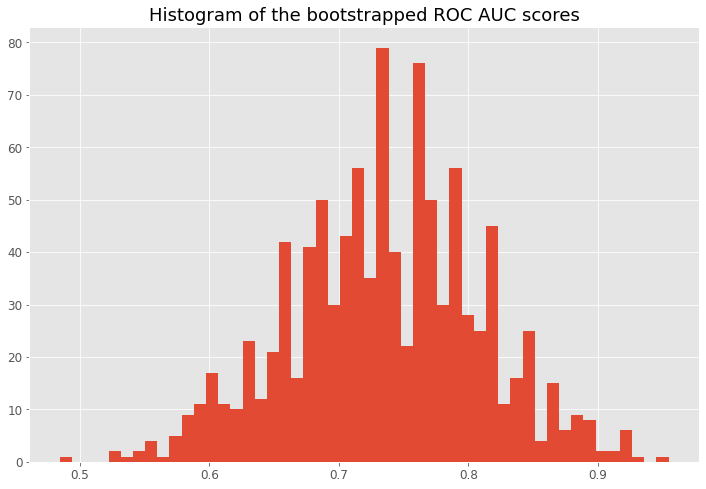

In [108]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [109]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.591 - 0.881]


Classification_report

In [110]:
print(classification_report(data_test['Died'], svc_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.75      0.75      0.75        20

    accuracy                           0.74        38
   macro avg       0.74      0.74      0.74        38
weighted avg       0.74      0.74      0.74        38



Accuracy scores

In [111]:
accu_svc = accuracy_score(data_test['Died'], svc_clf.predict(data_test_X))

In [112]:
accu_svc

0.7368421052631579

In [113]:
pd.crosstab(data_test['Died'], svc_clf.predict(data_test_X))

col_0   0   1
Died         
0      13   5
1       5  15

ROC and AUC

In [114]:
pred_proba_svc = svc_clf.predict_proba(data_test_X)

In [115]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(data_test['Died'], pred_proba_svc[:, 1])

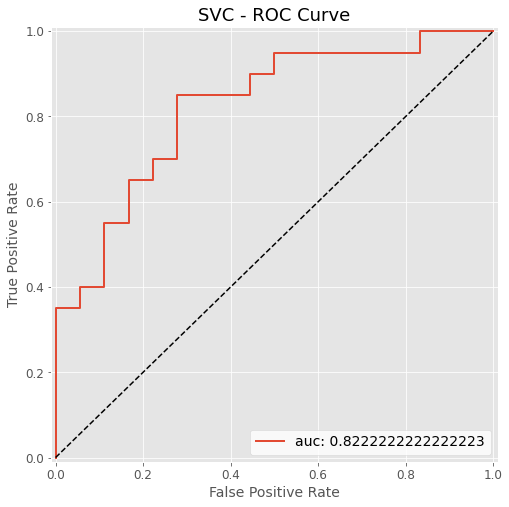

In [116]:
plot_roc_curve(fpr, tpr, auc_svc, svc_clf)

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

In [117]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'rb') as f:
    adab_clf = pickle.load(f)
adab_clf.fit(data_train_X, data_train['Died'])

AdaBoostClassifier(learning_rate=0.1, random_state=0)

In [118]:
import scipy.stats

y_pred = np.array(adab_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.786
Bootstrap #1 ROC area: 0.763
Bootstrap #2 ROC area: 0.763
Bootstrap #3 ROC area: 0.894
Bootstrap #4 ROC area: 0.713
Bootstrap #5 ROC area: 0.763
Bootstrap #6 ROC area: 0.763
Bootstrap #7 ROC area: 0.801
Bootstrap #8 ROC area: 0.836
Bootstrap #9 ROC area: 0.776
Bootstrap #10 ROC area: 0.789
Bootstrap #11 ROC area: 0.769
Bootstrap #12 ROC area: 0.787
Bootstrap #13 ROC area: 0.894
Bootstrap #14 ROC area: 0.884
Bootstrap #15 ROC area: 0.774
Bootstrap #16 ROC area: 0.792
Bootstrap #17 ROC area: 0.735
Bootstrap #18 ROC area: 0.763
Bootstrap #19 ROC area: 0.731
Bootstrap #20 ROC area: 0.794
Bootstrap #21 ROC area: 0.608
Bootstrap #22 ROC area: 0.728
Bootstrap #23 ROC area: 0.846
Bootstrap #24 ROC area: 0.824
Bootstrap #25 ROC area: 0.821
Bootstrap #26 ROC area: 0.732
Bootstrap #27 ROC area: 0.703
Bootstrap #28 ROC area: 0.842
Bootstrap #29 ROC area: 0.737
Bootstrap #30 ROC area: 0.789
Bootstrap #31 ROC area: 0.842
Bootstrap #32 ROC area: 0.770
Bootstrap #33 ROC area: 

Bootstrap #335 ROC area: 0.824
Bootstrap #336 ROC area: 0.761
Bootstrap #337 ROC area: 0.696
Bootstrap #338 ROC area: 0.767
Bootstrap #339 ROC area: 0.732
Bootstrap #340 ROC area: 0.869
Bootstrap #341 ROC area: 0.769
Bootstrap #342 ROC area: 0.713
Bootstrap #343 ROC area: 0.705
Bootstrap #344 ROC area: 0.779
Bootstrap #345 ROC area: 0.699
Bootstrap #346 ROC area: 0.686
Bootstrap #347 ROC area: 0.843
Bootstrap #348 ROC area: 0.780
Bootstrap #349 ROC area: 0.507
Bootstrap #350 ROC area: 0.759
Bootstrap #351 ROC area: 0.866
Bootstrap #352 ROC area: 0.842
Bootstrap #353 ROC area: 0.656
Bootstrap #354 ROC area: 0.793
Bootstrap #355 ROC area: 0.811
Bootstrap #356 ROC area: 0.783
Bootstrap #357 ROC area: 0.764
Bootstrap #358 ROC area: 0.767
Bootstrap #359 ROC area: 0.817
Bootstrap #360 ROC area: 0.686
Bootstrap #361 ROC area: 0.753
Bootstrap #362 ROC area: 0.789
Bootstrap #363 ROC area: 0.723
Bootstrap #364 ROC area: 0.797
Bootstrap #365 ROC area: 0.763
Bootstrap #366 ROC area: 0.753
Bootstra

Bootstrap #606 ROC area: 0.782
Bootstrap #607 ROC area: 0.878
Bootstrap #608 ROC area: 0.780
Bootstrap #609 ROC area: 0.729
Bootstrap #610 ROC area: 0.789
Bootstrap #611 ROC area: 0.816
Bootstrap #612 ROC area: 0.758
Bootstrap #613 ROC area: 0.767
Bootstrap #614 ROC area: 0.766
Bootstrap #615 ROC area: 0.878
Bootstrap #616 ROC area: 0.895
Bootstrap #617 ROC area: 0.816
Bootstrap #618 ROC area: 0.842
Bootstrap #619 ROC area: 0.592
Bootstrap #620 ROC area: 0.919
Bootstrap #621 ROC area: 0.889
Bootstrap #622 ROC area: 0.814
Bootstrap #623 ROC area: 0.840
Bootstrap #624 ROC area: 0.830
Bootstrap #625 ROC area: 0.786
Bootstrap #626 ROC area: 0.789
Bootstrap #627 ROC area: 0.861
Bootstrap #628 ROC area: 0.728
Bootstrap #629 ROC area: 0.768
Bootstrap #630 ROC area: 0.767
Bootstrap #631 ROC area: 0.789
Bootstrap #632 ROC area: 0.723
Bootstrap #633 ROC area: 0.787
Bootstrap #634 ROC area: 0.763
Bootstrap #635 ROC area: 0.768
Bootstrap #636 ROC area: 0.692
Bootstrap #637 ROC area: 0.780
Bootstra

Bootstrap #886 ROC area: 0.792
Bootstrap #887 ROC area: 0.846
Bootstrap #888 ROC area: 0.787
Bootstrap #889 ROC area: 0.836
Bootstrap #890 ROC area: 0.692
Bootstrap #891 ROC area: 0.921
Bootstrap #892 ROC area: 0.738
Bootstrap #893 ROC area: 0.764
Bootstrap #894 ROC area: 0.783
Bootstrap #895 ROC area: 0.786
Bootstrap #896 ROC area: 0.730
Bootstrap #897 ROC area: 0.728
Bootstrap #898 ROC area: 0.775
Bootstrap #899 ROC area: 0.622
Bootstrap #900 ROC area: 0.816
Bootstrap #901 ROC area: 0.869
Bootstrap #902 ROC area: 0.711
Bootstrap #903 ROC area: 0.739
Bootstrap #904 ROC area: 0.862
Bootstrap #905 ROC area: 0.895
Bootstrap #906 ROC area: 0.816
Bootstrap #907 ROC area: 0.921
Bootstrap #908 ROC area: 0.881
Bootstrap #909 ROC area: 0.753
Bootstrap #910 ROC area: 0.845
Bootstrap #911 ROC area: 0.628
Bootstrap #912 ROC area: 0.671
Bootstrap #913 ROC area: 0.721
Bootstrap #914 ROC area: 0.752
Bootstrap #915 ROC area: 0.784
Bootstrap #916 ROC area: 0.814
Bootstrap #917 ROC area: 0.734
Bootstra

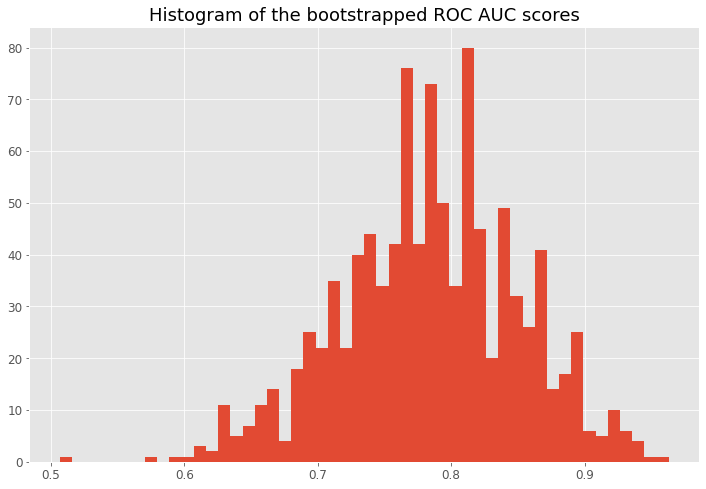

In [119]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [120]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.645 - 0.915]


Classification_report

In [121]:
print(classification_report(data_test['Died'], adab_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.77      0.85      0.81        20

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.79      0.79      0.79        38



Accuracy scores

In [122]:
accu_adab = accuracy_score(data_test['Died'], adab_clf.predict(data_test_X))

In [123]:
accu_adab

0.7894736842105263

In [124]:
pd.crosstab(data_test['Died'], svc_clf.predict(data_test_X))

col_0   0   1
Died         
0      13   5
1       5  15

In [125]:
pred_proba_adab = adab_clf.predict_proba(data_test_X)

In [126]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_adab[:, 1])
auc_adab = roc_auc_score(data_test['Died'], pred_proba_adab[:, 1])

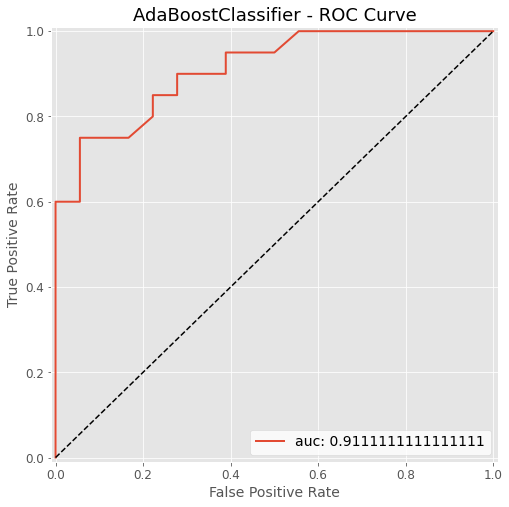

In [127]:
plot_roc_curve(fpr, tpr, auc_adab, adab_clf)

### _The ensemble model of voting classifier_

In [128]:
# Import model and retrain  ensemble_clf_final_round.pkl
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=0)),
                             ('rf',
                              RandomForestClassifier(max_depth=23,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=12,
                                                     n_estimators=44,
                                                     random_state=0)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=38,
                                                         min_samples_leaf=13,
                                                         min_samples_split=48,
                                                         n_estimators=162,
                                                         random_state=0)),
                             ('svc',
    

Classification_report

In [129]:
import scipy.stats

y_pred = np.array(ensemble_clf.predict(data_test_X))
y_true = np.array(data_test['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.817
Bootstrap #1 ROC area: 0.793
Bootstrap #2 ROC area: 0.805
Bootstrap #3 ROC area: 0.941
Bootstrap #4 ROC area: 0.668
Bootstrap #5 ROC area: 0.711
Bootstrap #6 ROC area: 0.816
Bootstrap #7 ROC area: 0.801
Bootstrap #8 ROC area: 0.825
Bootstrap #9 ROC area: 0.761
Bootstrap #10 ROC area: 0.921
Bootstrap #11 ROC area: 0.844
Bootstrap #12 ROC area: 0.901
Bootstrap #13 ROC area: 0.923
Bootstrap #14 ROC area: 0.923
Bootstrap #15 ROC area: 0.824
Bootstrap #16 ROC area: 0.786
Bootstrap #17 ROC area: 0.835
Bootstrap #18 ROC area: 0.789
Bootstrap #19 ROC area: 0.817
Bootstrap #20 ROC area: 0.919
Bootstrap #21 ROC area: 0.588
Bootstrap #22 ROC area: 0.798
Bootstrap #23 ROC area: 0.870
Bootstrap #24 ROC area: 0.807
Bootstrap #25 ROC area: 0.923
Bootstrap #26 ROC area: 0.801
Bootstrap #27 ROC area: 0.751
Bootstrap #28 ROC area: 0.868
Bootstrap #29 ROC area: 0.789
Bootstrap #30 ROC area: 0.822
Bootstrap #31 ROC area: 0.895
Bootstrap #32 ROC area: 0.830
Bootstrap #33 ROC area: 

Bootstrap #326 ROC area: 0.840
Bootstrap #327 ROC area: 0.869
Bootstrap #328 ROC area: 0.892
Bootstrap #329 ROC area: 0.719
Bootstrap #330 ROC area: 0.860
Bootstrap #331 ROC area: 0.699
Bootstrap #332 ROC area: 0.899
Bootstrap #333 ROC area: 0.895
Bootstrap #334 ROC area: 0.840
Bootstrap #335 ROC area: 0.908
Bootstrap #336 ROC area: 0.819
Bootstrap #337 ROC area: 0.740
Bootstrap #338 ROC area: 0.838
Bootstrap #339 ROC area: 0.711
Bootstrap #340 ROC area: 0.884
Bootstrap #341 ROC area: 0.819
Bootstrap #342 ROC area: 0.691
Bootstrap #343 ROC area: 0.744
Bootstrap #344 ROC area: 0.782
Bootstrap #345 ROC area: 0.770
Bootstrap #346 ROC area: 0.734
Bootstrap #347 ROC area: 0.825
Bootstrap #348 ROC area: 0.781
Bootstrap #349 ROC area: 0.588
Bootstrap #350 ROC area: 0.845
Bootstrap #351 ROC area: 0.860
Bootstrap #352 ROC area: 0.816
Bootstrap #353 ROC area: 0.683
Bootstrap #354 ROC area: 0.793
Bootstrap #355 ROC area: 0.870
Bootstrap #356 ROC area: 0.866
Bootstrap #357 ROC area: 0.850
Bootstra

Bootstrap #598 ROC area: 0.947
Bootstrap #599 ROC area: 0.878
Bootstrap #600 ROC area: 0.902
Bootstrap #601 ROC area: 0.814
Bootstrap #602 ROC area: 0.814
Bootstrap #603 ROC area: 0.843
Bootstrap #604 ROC area: 0.728
Bootstrap #605 ROC area: 0.817
Bootstrap #606 ROC area: 0.811
Bootstrap #607 ROC area: 0.901
Bootstrap #608 ROC area: 0.880
Bootstrap #609 ROC area: 0.851
Bootstrap #610 ROC area: 0.816
Bootstrap #611 ROC area: 0.842
Bootstrap #612 ROC area: 0.872
Bootstrap #613 ROC area: 0.842
Bootstrap #614 ROC area: 0.765
Bootstrap #615 ROC area: 0.923
Bootstrap #616 ROC area: 0.816
Bootstrap #617 ROC area: 0.816
Bootstrap #618 ROC area: 0.868
Bootstrap #619 ROC area: 0.655
Bootstrap #620 ROC area: 0.919
Bootstrap #621 ROC area: 0.839
Bootstrap #622 ROC area: 0.819
Bootstrap #623 ROC area: 0.864
Bootstrap #624 ROC area: 0.847
Bootstrap #625 ROC area: 0.882
Bootstrap #626 ROC area: 0.842
Bootstrap #627 ROC area: 0.839
Bootstrap #628 ROC area: 0.758
Bootstrap #629 ROC area: 0.813
Bootstra

Bootstrap #880 ROC area: 0.923
Bootstrap #881 ROC area: 0.840
Bootstrap #882 ROC area: 0.878
Bootstrap #883 ROC area: 0.790
Bootstrap #884 ROC area: 0.699
Bootstrap #885 ROC area: 0.880
Bootstrap #886 ROC area: 0.789
Bootstrap #887 ROC area: 0.880
Bootstrap #888 ROC area: 0.793
Bootstrap #889 ROC area: 0.908
Bootstrap #890 ROC area: 0.817
Bootstrap #891 ROC area: 0.895
Bootstrap #892 ROC area: 0.789
Bootstrap #893 ROC area: 0.811
Bootstrap #894 ROC area: 0.839
Bootstrap #895 ROC area: 0.746
Bootstrap #896 ROC area: 0.778
Bootstrap #897 ROC area: 0.787
Bootstrap #898 ROC area: 0.751
Bootstrap #899 ROC area: 0.678
Bootstrap #900 ROC area: 0.843
Bootstrap #901 ROC area: 0.830
Bootstrap #902 ROC area: 0.656
Bootstrap #903 ROC area: 0.761
Bootstrap #904 ROC area: 0.901
Bootstrap #905 ROC area: 0.842
Bootstrap #906 ROC area: 0.816
Bootstrap #907 ROC area: 0.947
Bootstrap #908 ROC area: 0.952
Bootstrap #909 ROC area: 0.892
Bootstrap #910 ROC area: 0.825
Bootstrap #911 ROC area: 0.686
Bootstra

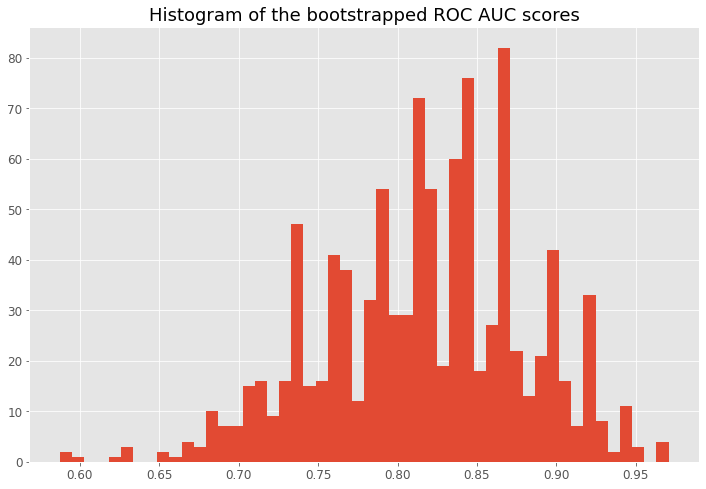

In [130]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [131]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.686 - 0.929]


In [132]:
print(classification_report(data_test['Died'], ensemble_clf.predict(data_test_X)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.84      0.80      0.82        20

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



Accuracy scores

In [133]:
accu_ensemble = accuracy_score(data_test['Died'], ensemble_clf.predict(data_test_X))


In [134]:
accu_ensemble

0.8157894736842105

In [135]:
pd.crosstab(data_test['Died'], ensemble_clf.predict(data_test_X))

col_0   0   1
Died         
0      15   3
1       4  16

ROC and AUC

In [136]:
pred_proba_ensemble = ensemble_clf.predict_proba(data_test_X)

In [137]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_ensemble[:, 1])
auc_ensemble = roc_auc_score(data_test['Died'], pred_proba_ensemble[:, 1])

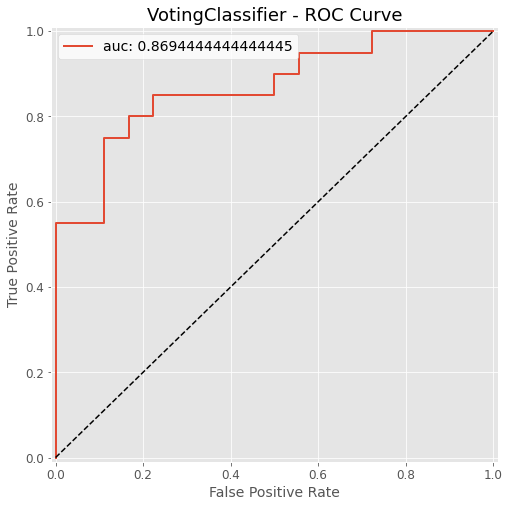

In [138]:
plot_roc_curve(fpr, tpr, auc_ensemble, ensemble_clf)

## 7. Summary
Support vector machine, random forests and gradient boosting classifiers are better than  in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The classifiers performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

In [139]:
pd.DataFrame([[accu_lr, accu_svc, accu_rf, accu_gbm, accu_adab,accu_ensemble],
              [auc_lr, auc_svc, auc_rf, auc_gbm, auc_adab, auc_ensemble]],
              index=['Accuracy(>=.5)', 'Area Under (ROC) Curve'],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine', 'AdaBoostClassifier ','VotingClassifier'])

Logistic Regression  Support vector machine  \
Accuracy(>=.5)                     0.710526                0.736842   
Area Under (ROC) Curve             0.836111                0.822222   

                        Random forests  Gradient boosting machine  \
Accuracy(>=.5)                0.815789                   0.815789   
Area Under (ROC) Curve        0.880556                   0.863889   

                        AdaBoostClassifier   VotingClassifier  
Accuracy(>=.5)                     0.789474          0.815789  
Area Under (ROC) Curve             0.911111          0.869444

### Concat prediction_proba for each model to test set, save test set

In [140]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]
data_test['rf_pred_proba'] = pred_proba_rf[:, 1]
data_test['svc_pred_proba'] = pred_proba_svc[:, 1]
data_test['gbm_pred_proba'] = pred_proba_gbm[:, 1]
data_test['adab_pred_proba'] = pred_proba_adab[:, 1]
data_test['ensemble_pred_proba'] = pred_proba_ensemble[:, 1]

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [141]:
data_test.to_csv(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\CA_test_set_with_predictions.csv'.format(len(data_train)), index=False)

## Class breakdown per model

In [142]:
def plot_class_breakdown_hist(df, var, var_name,var_name2, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.Died == 1].hist(alpha=.5, label='Died', color = "red", **histkwargs)
    df[var][df.Died == 0].hist(alpha=.5, label='Survived', color = "green", **histkwargs)
    plt.xlabel(var_name)
    plt.ylabel(var_name2)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.ylim(ymax=5, ymin=0)
    plt.xlim(xmax=1.0, xmin=0.0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

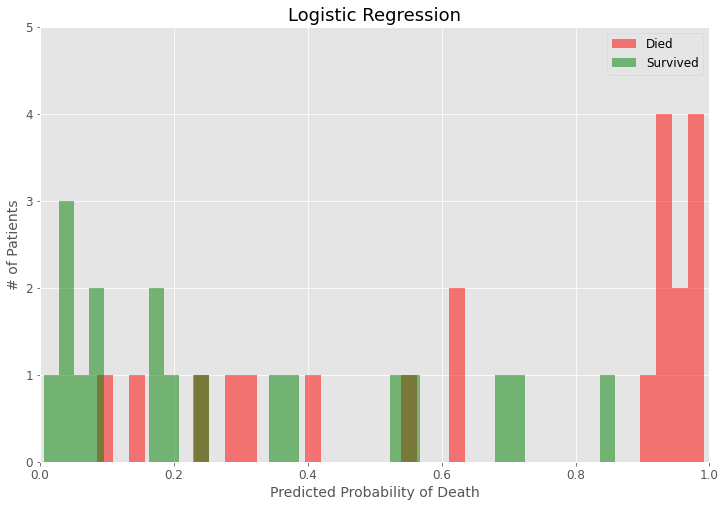

In [143]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='Predicted Probability of Death', var_name2='# of Patients',
#                          plot_title='Logistic Regression Class Breakdown', bins=12)
                          plot_title='Logistic Regression', bins=38)

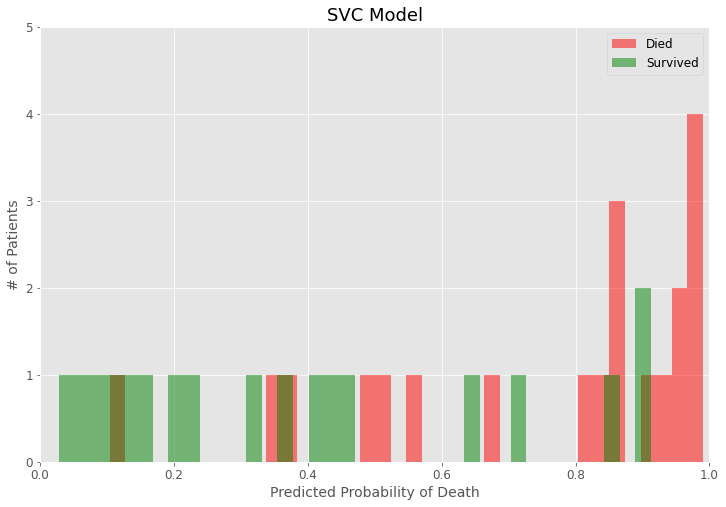

In [146]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='Predicted Probability of Death', var_name2='# of Patients',
                          plot_title='SVC Model', bins=38)

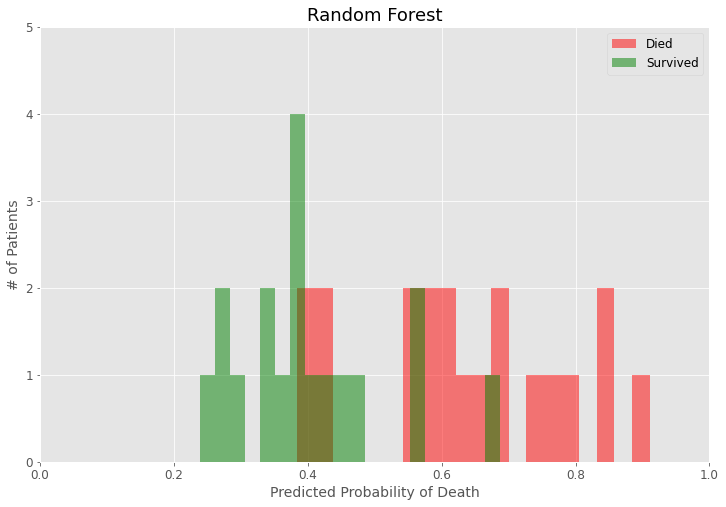

In [147]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='Random Forest', bins=20)

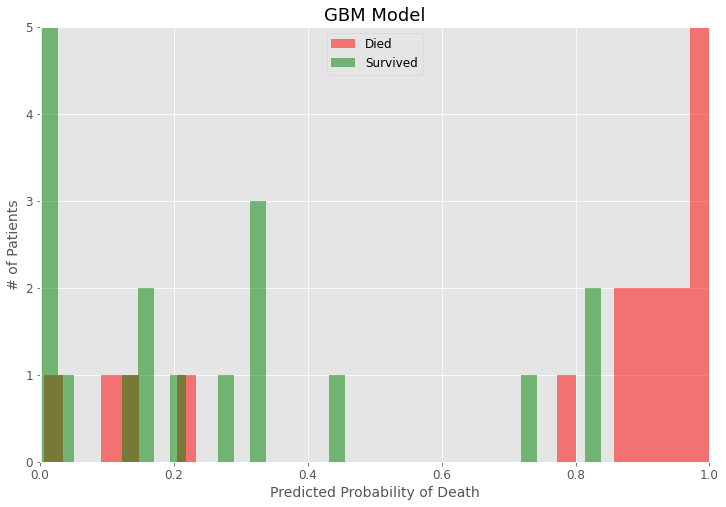

In [148]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='GBM Model', bins=35)

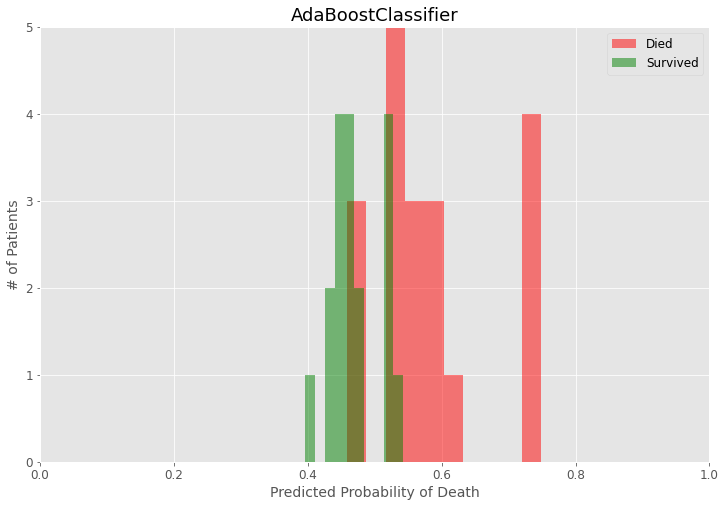

In [153]:
plot_class_breakdown_hist(data_test, 'adab_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='AdaBoostClassifier', bins=10)

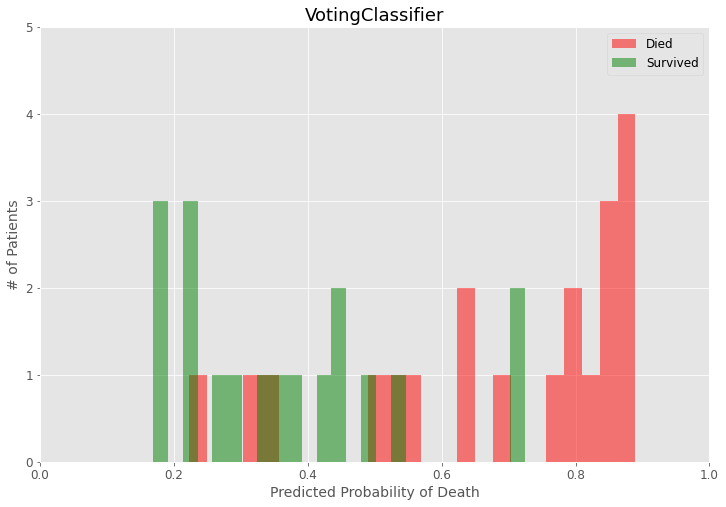

In [155]:
plot_class_breakdown_hist(data_test, 'ensemble_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='VotingClassifier', bins=25)

In [156]:
import numpy as np
from sklearn import metrics

model = dict()
actual = dict()
predict = dict()
color = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6

model[0] = 'Logistic Regression'
actual[0] = data_test.Died
predict[0] = data_test.lr_pred_proba
color[0] = 'blue'

model[1] = 'Support vector machine'
actual[1] = data_test.Died
predict[1] = data_test.svc_pred_proba
color[1] = 'orange'

model[2] = 'Random forests'
actual[2] = data_test.Died
predict[2] = data_test.rf_pred_proba
color[2] = 'green'

model[3] = 'Gradient boosting machine'
actual[3] = data_test.Died
predict[3] = data_test.gbm_pred_proba
color[3] = 'black'

model[4] = 'AdaBoostClassifier'
actual[4] = data_test.Died
predict[4] = data_test.adab_pred_proba
color[4] = 'brown'

model[5] = 'VotingClassifier'
actual[5] = data_test.Died
predict[5] = data_test.ensemble_pred_proba
color[5] = 'red'

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = metrics.roc_curve(actual[i], predict[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

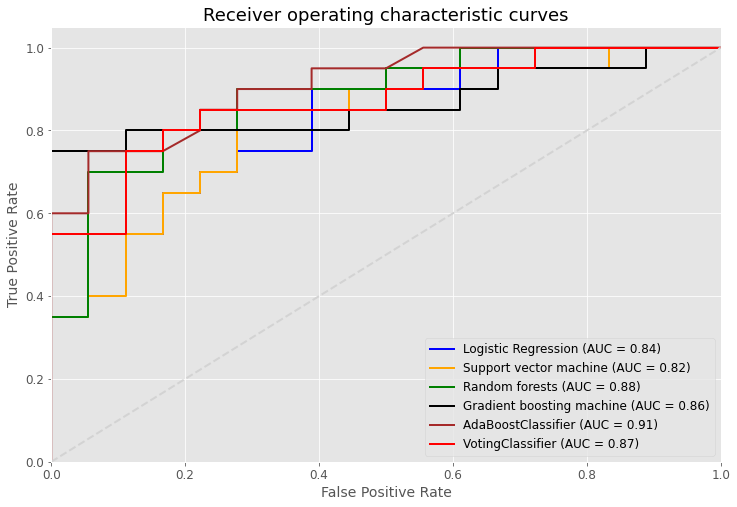

In [157]:
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=lw, label=model[i]+' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()

In [158]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
data_test['Died'].sum() / len(data_test['Died'])

# calculate per age group
#age_groups = ['<40','40~65','>=65']
age_groups = ['<12','12~40','40~65','>=65']
predicted_mortality = []
for group in age_groups:
    predicted_mortality.append(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died'].sum() 
                               / len(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died']))
predicted_mortality

# create list per model
models = ['lr_pred_proba','svc_pred_proba','rf_pred_proba',
          'gbm_pred_proba','adab_pred_proba','ensemble_pred_proba','Died']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.Age == group) & (~data_test[model].isna())][model].sum() 
                                      / len(data_test[(data_test.Age == group) & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_mortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'Died':'True Ratio',
                                                 'lr_pred_proba':'Logistic Regression',
                                                  'svc_pred_proba':'Support Vector Classifier',
                                                  'rf_pred_proba':'Random Forest Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'adab_pred_proba':'AdaBoostClassifier',
                                                 'ensemble_pred_proba':'VotingClassifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'<12':'<12',
                                                '12~40':'12~40',
                                               '40~65':'40~65',
                                               '>=65':'>=65'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

Logistic Regression  Support Vector Classifier  \
Age group                                                   
<12                      0.295                      0.432   
12~40                    0.457                      0.538   
40~65                    0.545                      0.614   
>=65                     0.492                      0.562   

           Random Forest Classifier  Gradient Boosted Machine  \
Age group                                                       
<12                           0.541                     0.662   
12~40                         0.563                     0.582   
40~65                         0.512                     0.464   
>=65                          0.510                     0.657   

           AdaBoostClassifier  VotingClassifier  True Ratio  
Age group                                                    
<12                     0.543             0.495       0.500  
12~40                   0.543             0.536       0.556  
40~65                   0.518             0.531       0.500  
>=65                    0.531             0.551       0.571

In [159]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted CA by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted CA by Age Group (Rounded).csv')

<AxesSubplot:title={'center':'Predicted Mortality Ratio by Age Group'}, xlabel='Age group'>

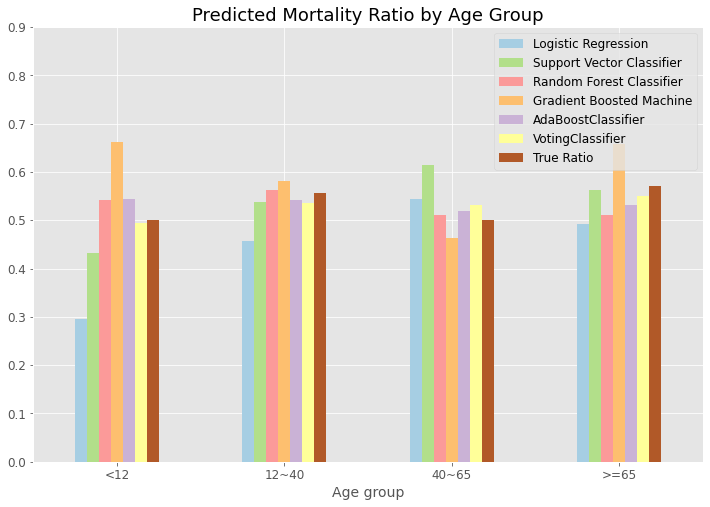

In [162]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Predicted Mortality Ratio by Age Group',
                                       colormap='Paired')

## List of all features used

In [163]:
data_train_X.columns.to_frame().to_csv('Final features for CA_prediction model.csv') # Save to CSV
data_train_X.columns.to_frame()

0
Gender                                      Gender
Age                                            Age
BMI                                            BMI
Comorbidity_diabetes          Comorbidity_diabetes
Comorbidity_hypertension  Comorbidity_hypertension
Comorbidity_CAD                    Comorbidity_CAD
Comorbidity_pulmonary        Comorbidity_pulmonary
Comorbidity_hepatic            Comorbidity_hepatic
Comorbidity_renal                Comorbidity_renal
Comorbidity_neurological  Comorbidity_neurological
Comorbidity_tumor                Comorbidity_tumor
Surgical_type                        Surgical_type
Emergency                                Emergency
Trauma                                      Trauma
Anaesthetic_type                  Anaesthetic_type
Operative_position              Operative_position
ASA                                            ASA
Timing_arrest                        Timing_arrest
Defibrillate                          Defibrillate
Cause_arrest                          Cause_arrest
Hemorrhage                              Hemorrhage
Blood_transfusion                Blood_transfusion
Epinephrine                            Epinephrine
Atropine                                  Atropine
Amiodarone                              Amiodarone
Ephedrine                                Ephedrine
Methoxamine                            Methoxamine
CPR                                            CPR